In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler,OneHotEncoder, RobustScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_fscore_support,
    confusion_matrix, brier_score_loss,precision_recall_curve, f1_score,
    classification_report, roc_curve, auc)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.distributions as dist
from pyro.nn import PyroSample, PyroModule
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam
from pyro.infer.autoguide import AutoDiagonalNormal
from torch.utils.data import TensorDataset, DataLoader
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from scipy.stats import spearmanr
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.isotonic import IsotonicRegression
import shap
from lime.lime_tabular import LimeTabularExplainer

# EDA

In [2]:
# Load data
train = pd.read_csv('UNSW_NB15_training-set.csv')
test = pd.read_csv('UNSW_NB15_testing-set.csv')

# View basic information
print(train.head(5))
print(train.shape)    
print(train.dtypes)
print(train.isnull().sum())

   id       dur proto service state  spkts  dpkts  sbytes  dbytes       rate  \
0   1  0.121478   tcp       -   FIN      6      4     258     172  74.087490   
1   2  0.649902   tcp       -   FIN     14     38     734   42014  78.473372   
2   3  1.623129   tcp       -   FIN      8     16     364   13186  14.170161   
3   4  1.681642   tcp     ftp   FIN     12     12     628     770  13.677108   
4   5  0.449454   tcp       -   FIN     10      6     534     268  33.373826   

   ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
0  ...                 1               1             0           0   
1  ...                 1               2             0           0   
2  ...                 1               3             0           0   
3  ...                 1               3             1           1   
4  ...                 1              40             0           0   

   ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  attack_cat  \
0                 0   

In [3]:
# Define variable types
nominal_cols = ['proto','state','service']
binary_cols = ['is_sm_ips_ports','is_ftp_login']
drop_cols = ['id','attack_cat']
target_col = 'label'

# Convert dtypes
for df in [train, test]:
    for c in nominal_cols + binary_cols:
        df[c] = df[c].astype('category')
    df[target_col] = df[target_col].astype('category')

# Generate X & y for modeling
X_train = train.drop(columns=drop_cols + [target_col])
y_train = train[target_col]

X_test = test.drop(columns=drop_cols + [target_col])
y_test = test[target_col]

# Other numeric features
numeric_cols = X_train.select_dtypes(include=['int64','float64']).columns.tolist()

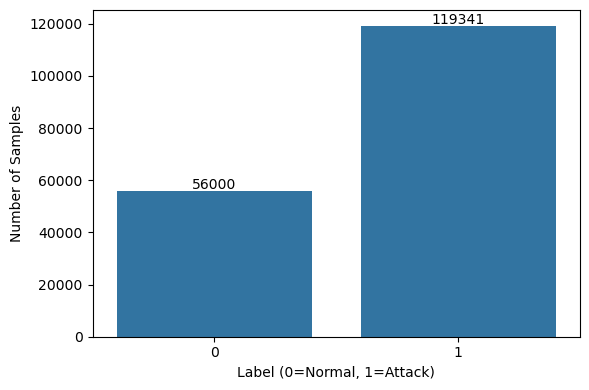

In [4]:
# Label distribution visualization
plt.figure(figsize=(6, 4))

ax = sns.countplot(x=y_train, order=y_train.cat.categories)
plt.xlabel("Label (0=Normal, 1=Attack)")
plt.ylabel("Number of Samples")
## plt.title("Training Set Label Distribution")

total = len(y_train)
for p in ax.patches:
    count = p.get_height()
    x = p.get_x() + p.get_width() / 2
    ax.annotate(f'{int(count)}',
                xy=(x, count),
                xytext=(0, 1),
                textcoords='offset points',
                ha='center')

plt.tight_layout()
plt.show()

In [5]:
# Descriptive statistics
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
dur,175341.0,1.359389e+00,6.480249e+00,0.0,0.000008,0.001582,6.680690e-01,5.999999e+01
spkts,175341.0,2.029866e+01,1.368876e+02,1.0,2.000000,2.000000,1.200000e+01,9.616000e+03
dpkts,175341.0,1.896959e+01,1.102583e+02,0.0,0.000000,2.000000,1.000000e+01,1.097400e+04
sbytes,175341.0,8.844844e+03,1.747656e+05,28.0,114.000000,430.000000,1.418000e+03,1.296523e+07
dbytes,175341.0,1.492892e+04,1.436542e+05,0.0,0.000000,164.000000,1.102000e+03,1.465555e+07
rate,175341.0,9.540619e+04,1.654010e+05,0.0,32.786140,3225.806520,1.250000e+05,1.000000e+06
sttl,175341.0,1.795470e+02,1.029400e+02,0.0,62.000000,254.000000,2.540000e+02,2.550000e+02
dttl,175341.0,7.960957e+01,1.105069e+02,0.0,0.000000,29.000000,2.520000e+02,2.540000e+02
sload,175341.0,7.345403e+07,1.883574e+08,0.0,13053.338870,879674.750000,8.888889e+07,5.988000e+09
dload,175341.0,6.712056e+05,2.421312e+06,0.0,0.000000,1447.022705,2.784487e+04,2.242273e+07


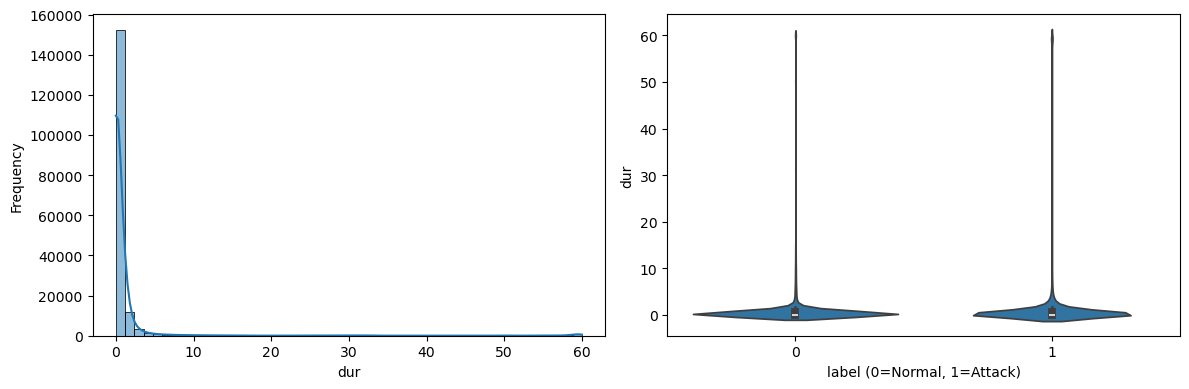

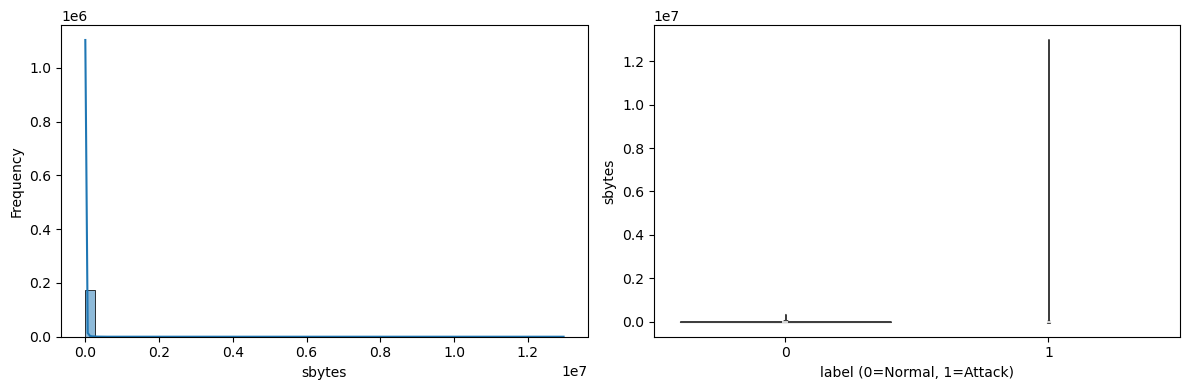

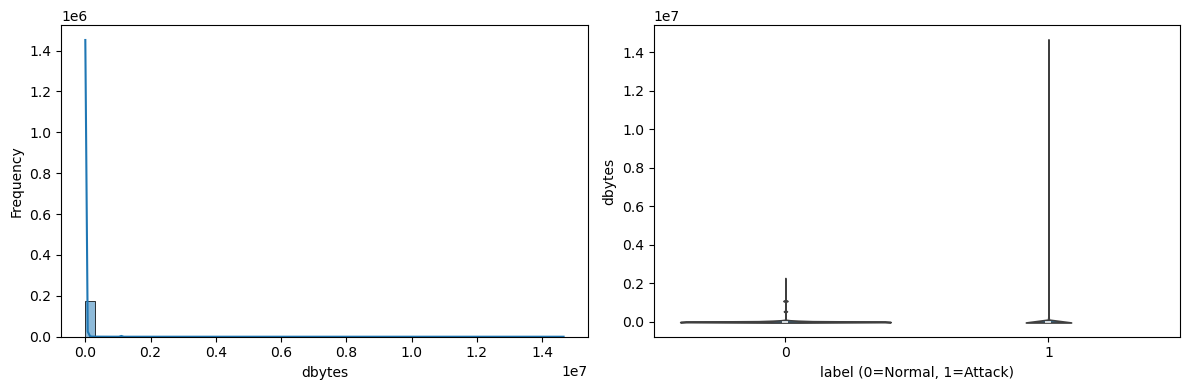

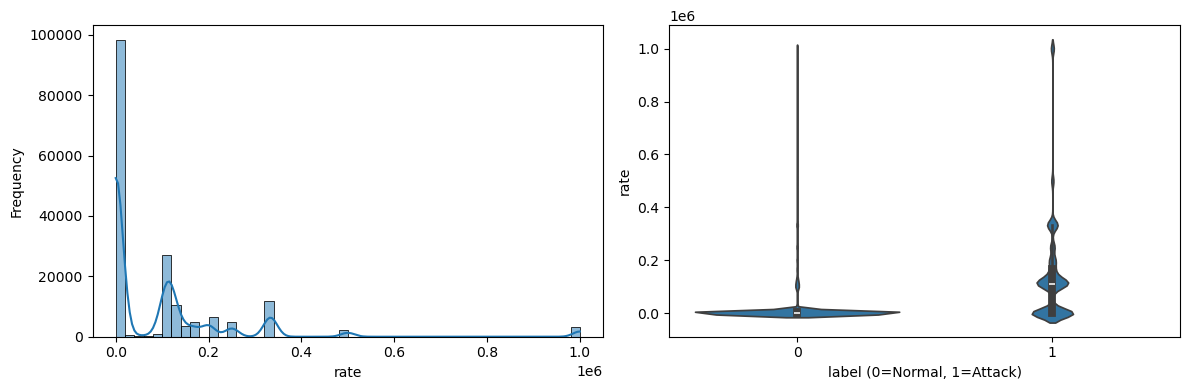

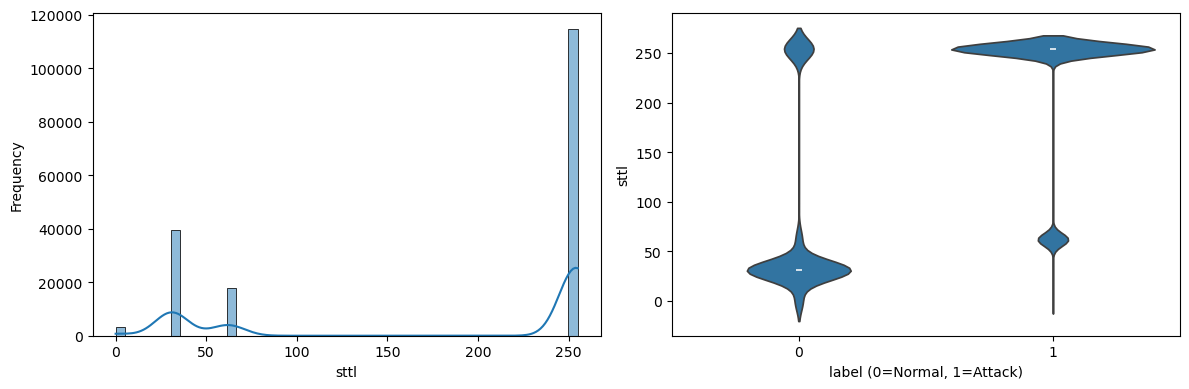

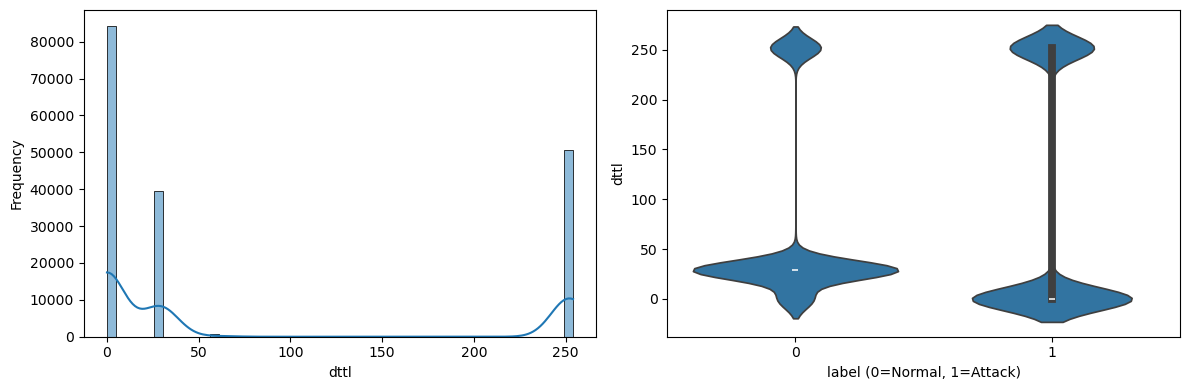

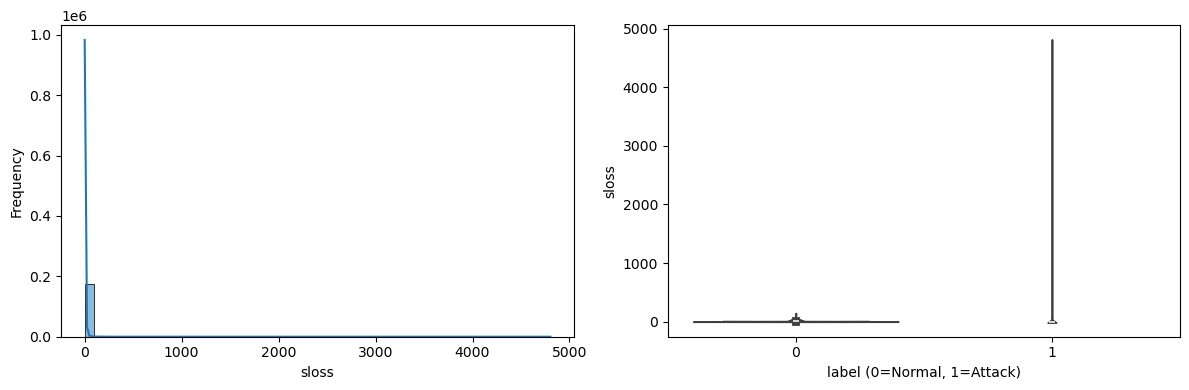

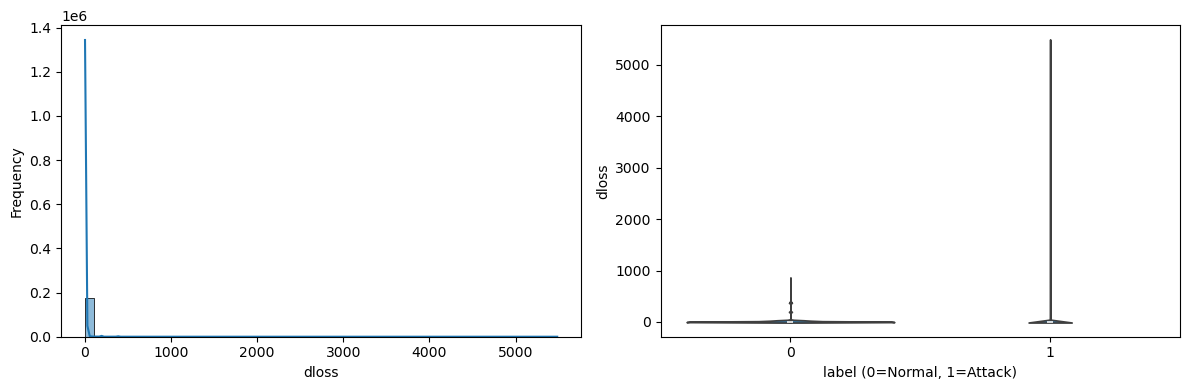

In [6]:
# Merge features and labels
df_train = X_train.copy()
df_train['label'] = y_train.astype(int)

# Specify numeric features to visualize
num_cols = ["dur", "sbytes", "dbytes", "rate", "sttl", "dttl", "sloss", "dloss"]

# Loop to plot histogram & boxplot
for col in num_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # histogram of distribution
    sns.histplot(df_train[col], bins=50, kde=True, ax=axes[0])
    ## axes[0].set_title(f"{col} Histogram")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("Frequency")
    
    # violin plot grouped by label
    sns.violinplot(x='label', y=col, data=df_train, ax=axes[1], inner="box")
    ## axes[1].set_title(f"{col} Violin Plot (Grouped by label)")
    axes[1].set_xlabel("label (0=Normal, 1=Attack)")
    axes[1].set_ylabel(col)
    
    plt.tight_layout()
    plt.show()

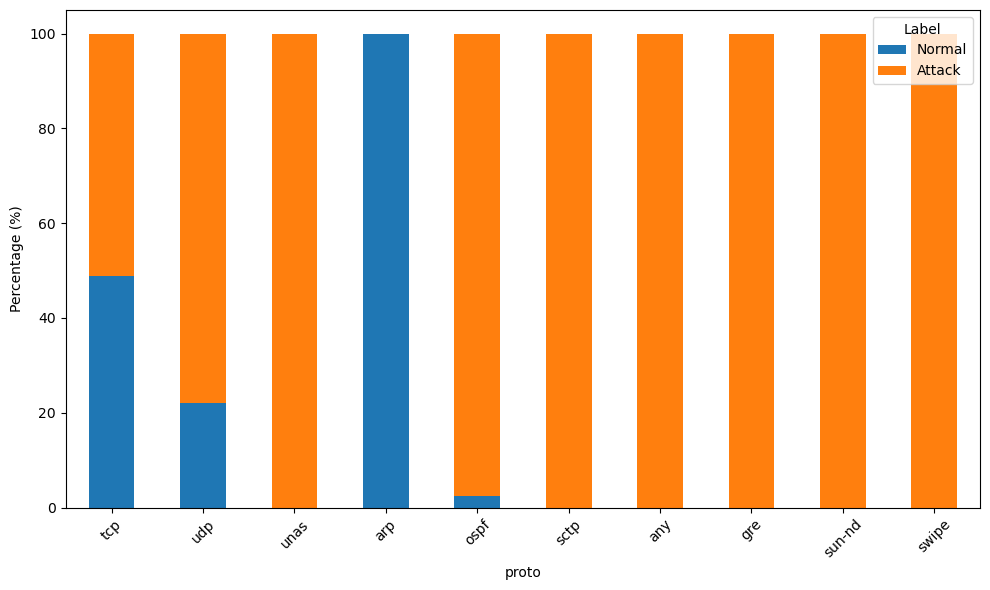

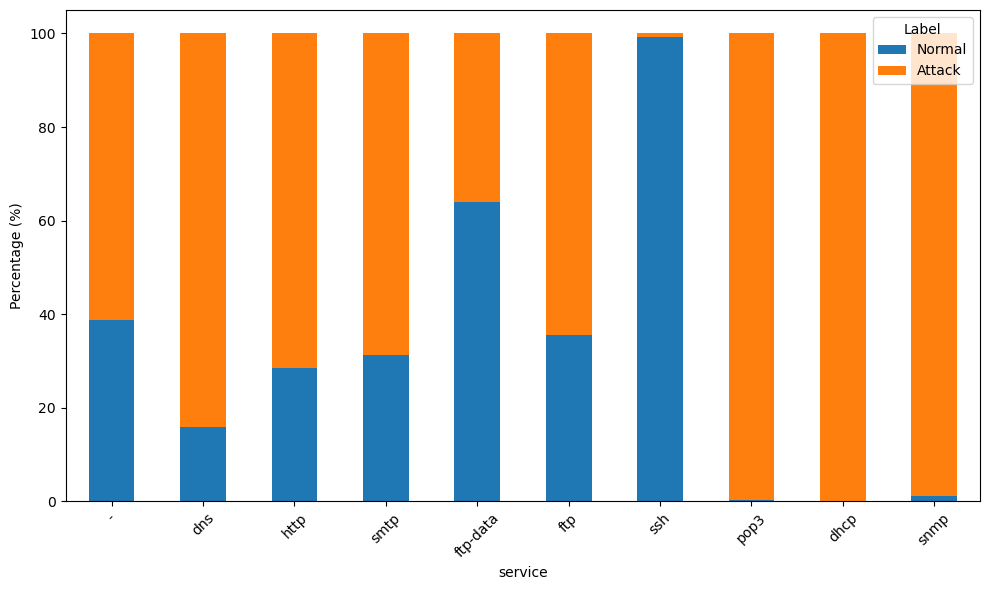

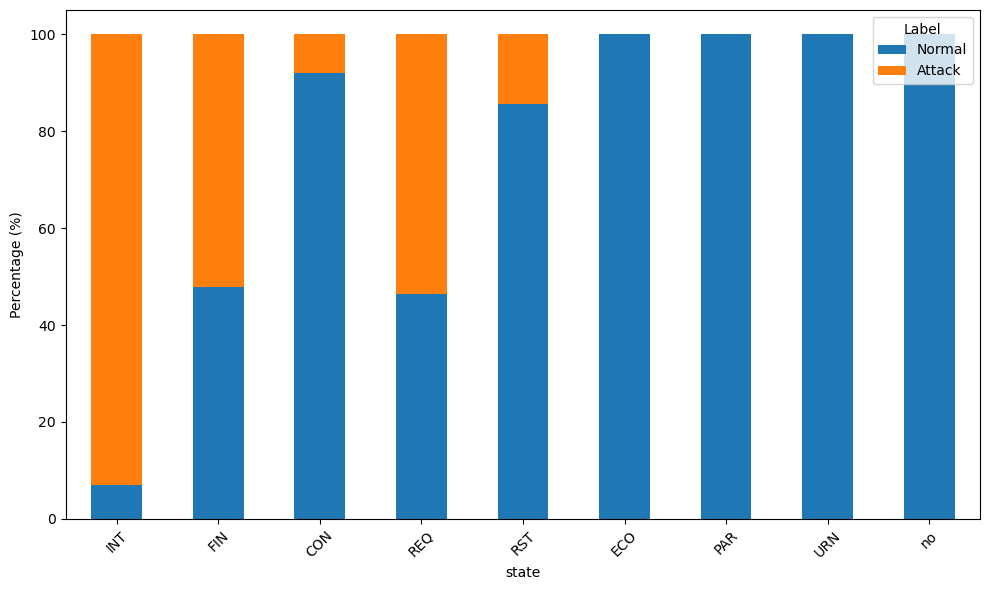

In [7]:
cat_cols = ["proto", "service", "state"]
for col in cat_cols:
    # Get categories
    top = df_train[col].value_counts().nlargest(10).index
    
    # Calculate percentage of Normal/Attack in each category (row-normalized)
    pct = pd.crosstab(df_train[col], df_train['label'],
                      normalize='index').loc[top] * 100
    pct.columns = ['Normal', 'Attack']
    
    # Plot stacked percentage bar chart
    ax = pct.plot(kind='bar',
                  stacked=True,
                  figsize=(10, 6))
    
    ## ax.set_title(f"{col} — Normal vs Attack Percentage Stacked Chart")
    ax.set_xlabel(col)
    ax.set_ylabel("Percentage (%)")
    ax.legend(title='Label', loc='upper right')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

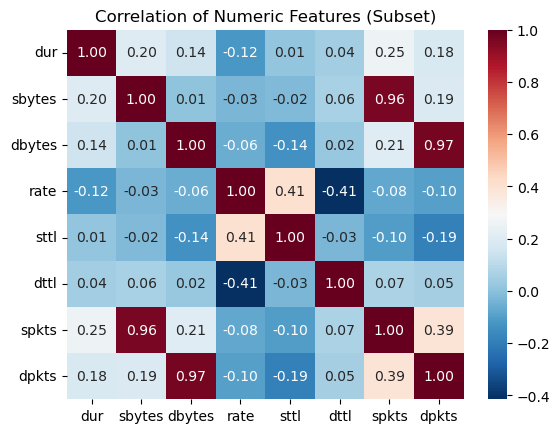

dpkts    -0.118591
dbytes   -0.076871
spkts    -0.052178
sbytes    0.018576
dur       0.036175
dttl      0.095049
rate      0.337979
sttl      0.692741
label     1.000000
Name: label, dtype: float64


In [8]:
# Correlation between features
sel = ["dur", "sbytes", "dbytes", "rate", "sttl", "dttl", "spkts", "dpkts"]
corr = X_train[sel].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r")
plt.title("Correlation of Numeric Features (Subset)")
plt.show()

# Correlation between label and numeric features
corr_label = df_train[sel + ["label"]].corr()["label"].sort_values()
print(corr_label)

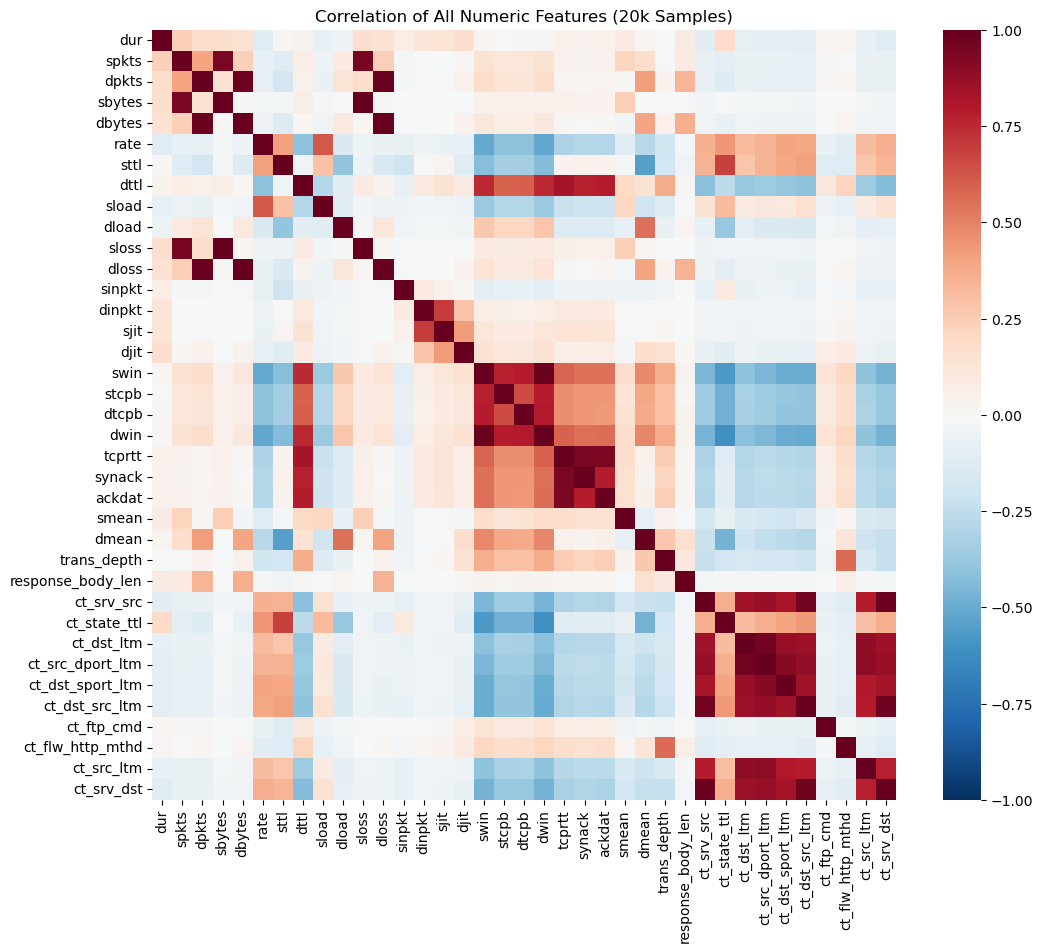

In [9]:
# Full feature correlation heatmap (sampled)
sub = X_train.sample(20000)
corr = sub.select_dtypes(include="number").corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="RdBu_r", center=0, vmax=1, vmin=-1)
plt.title("Correlation of All Numeric Features (20k Samples)")
plt.show()

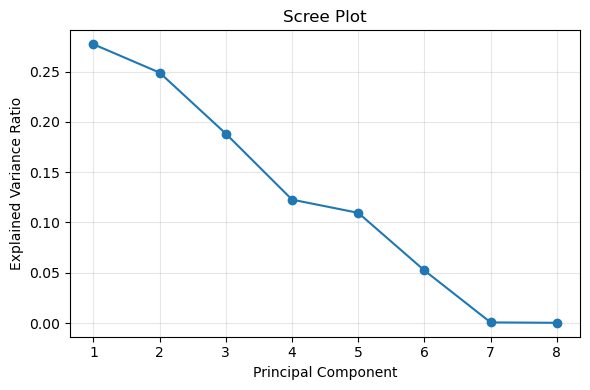

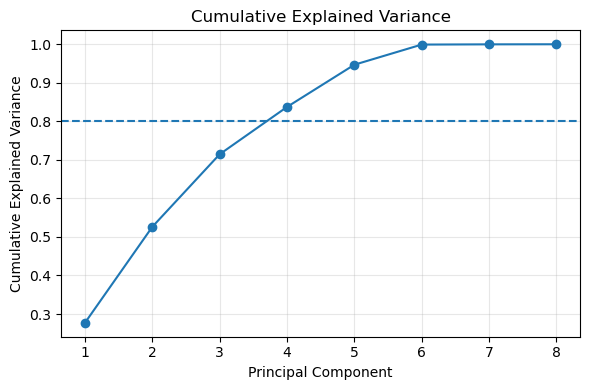

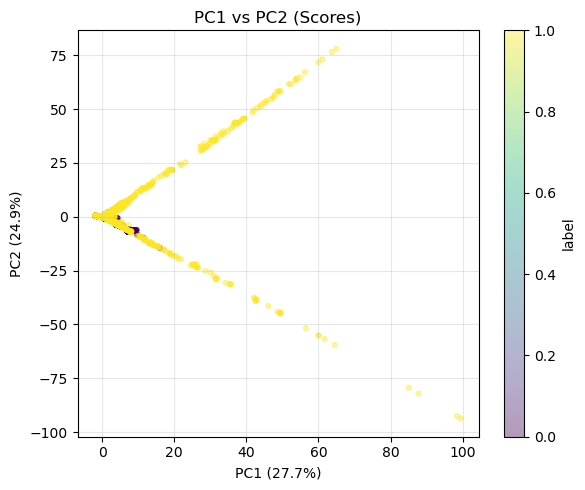

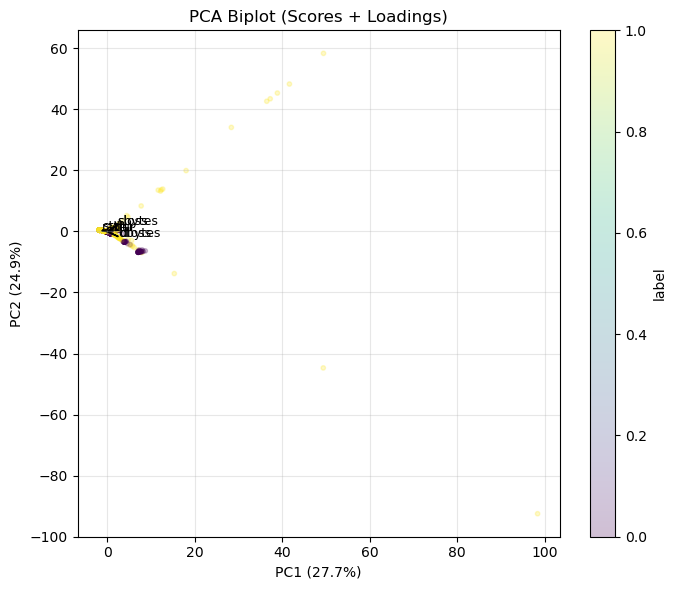

In [10]:
# PCA
sample = df_train
X = sample[num_cols].copy()
y = sample["label"].values if "label" in sample.columns else None

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_comp = min(10, X.shape[1])  
pca = PCA(n_components=n_comp, random_state=42)
scores = pca.fit_transform(X_scaled)
loadings = pca.components_.T
expl = pca.explained_variance_ratio_

# Scree plot
plt.figure(figsize=(6,4))
plt.plot(range(1, n_comp+1), expl, marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Cumulative explained variance
plt.figure(figsize=(6,4))
plt.plot(range(1, n_comp+1), np.cumsum(expl), marker='o')
# Reference line: 80%
plt.axhline(0.8, linestyle='--')
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# PC1–PC2 score scatter plot
plt.figure(figsize=(6,5))
if y is None:
    plt.scatter(scores[:,0], scores[:,1], s=12, alpha=0.4)
else:
    sc = plt.scatter(scores[:,0], scores[:,1], c=y, s=12, alpha=0.4)
    cbar = plt.colorbar(sc)
    cbar.set_label("label")
plt.xlabel(f"PC1 ({expl[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({expl[1]*100:.1f}%)")
plt.title("PC1 vs PC2 (Scores)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Biplot
K = min(15, X.shape[1])
# Select top K features contributing most to PC1/PC2 (by squared loadings sum)
feat_strength = np.sum(loadings[:, :2]**2, axis=1)
idx_top = np.argsort(feat_strength)[::-1][:K]

plt.figure(figsize=(7,6))
n_show = min(6000, scores.shape[0])
sel = np.random.RandomState(42).choice(scores.shape[0], n_show, replace=False)
if y is None:
    plt.scatter(scores[sel,0], scores[sel,1], s=10, alpha=0.25)
else:
    sc = plt.scatter(scores[sel,0], scores[sel,1], c=y[sel], s=10, alpha=0.25)
    cbar = plt.colorbar(sc)
    cbar.set_label("label")

# Loading vectors
scale_x = 0.95 * (np.percentile(scores[:,0], 99) - np.percentile(scores[:,0], 1))
scale_y = 0.95 * (np.percentile(scores[:,1], 99) - np.percentile(scores[:,1], 1))
for i in idx_top:
    xv = loadings[i,0] * scale_x
    yv = loadings[i,1] * scale_y
    plt.arrow(0, 0, xv, yv, head_width=0.02*scale_x, length_includes_head=True, alpha=0.8)
    plt.text(xv*1.05, yv*1.05, str(X.columns[i]), fontsize=9)

plt.xlabel(f"PC1 ({expl[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({expl[1]*100:.1f}%)")
plt.title("PCA Biplot (Scores + Loadings)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Feature Engineering

In [11]:
nominal_cols = ['proto', 'state', 'service']
binary_cols = ['is_sm_ips_ports', 'is_ftp_login']
cat_cols = nominal_cols + binary_cols
target_col = 'label'

# Make copies to avoid modifying originals
Xtr = X_train.copy()
Xte = X_test.copy()

# Ensure categorical columns are dtype 'category'
for df in (Xtr, Xte):
    for c in cat_cols:
        if df[c].dtype.name != 'category':
            df[c] = df[c].astype('category')

# Numeric columns set, drop constant columns
num_cols = Xtr.select_dtypes(include=[np.number]).columns.tolist()

# Drop constant/nearly-constant numeric columns (only 1 unique value)
const_cols = [c for c in num_cols if Xtr[c].nunique(dropna=False) <= 1]
if const_cols:
    Xtr.drop(columns=const_cols, inplace=True)
    Xte.drop(columns=const_cols, inplace=True)
    num_cols = [c for c in num_cols if c not in const_cols]
    print(f"Constant columns have been removed: {const_cols}")

# Collinearity handling (assess on training set only)
corr = Xtr[num_cols].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
high_corr = [c for c in upper.columns if any(upper[c] > 0.95)]
if high_corr:
    Xtr.drop(columns=high_corr, inplace=True)
    Xte.drop(columns=high_corr, inplace=True)
    num_cols = [c for c in num_cols if c not in high_corr]
    print(f"Highly collinear columns have been removed(|r|>0.95): {high_corr}")

# Apply log1p to highly skewed non-negative numeric columns
skew_s = Xtr[num_cols].skew(numeric_only=True)
skew_cols = [c for c in num_cols if (skew_s[c] > 1.0 and Xtr[c].min() >= 0)]
if skew_cols:
    Xtr[skew_cols] = np.log1p(Xtr[skew_cols])
    # Apply log1p to the same columns in the test set
    Xte[skew_cols] = np.log1p(Xte[skew_cols])
    print(f"log1p handle columns (skewness > 1 and non - negative): {skew_cols}")

# Winsorize by quantiles (fit 1%/99% thresholds on training set）
q_low  = Xtr[num_cols].quantile(0.01)
q_high = Xtr[num_cols].quantile(0.99)
Xtr[num_cols] = Xtr[num_cols].clip(q_low, q_high, axis=1)
Xte[num_cols] = Xte[num_cols].clip(q_low, q_high, axis=1)

# ColumnTransformer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  RobustScaler())
])

try:
    ohe = OneHotEncoder(handle_unknown='ignore', drop='if_binary', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', drop='if_binary', sparse=False)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', ohe)
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop'
)

# Fit and transform
X_train_fe = preprocess.fit_transform(Xtr)
X_test_fe = preprocess.transform(Xte)

# Export feature names
num_names = num_cols
ohe = preprocess.named_transformers_['cat']['ohe']
cat_names = ohe.get_feature_names_out(cat_cols).tolist()
feature_names = num_names + cat_names

# Export feature names for interpretability
num_names = num_cols
ohe = preprocess.named_transformers_['cat']['ohe']
cat_names = ohe.get_feature_names_out(cat_cols).tolist()
feature_names = num_names + cat_names

print("Shape after feature engineering:", X_train_fe.shape, X_test_fe.shape)
print("Number of numerical columns / Number of columns after category expansion:", len(num_names), len(cat_names))

# Convert y to numpy
y_train_np = y_train.astype(int).to_numpy()
y_test_np = y_test.astype(int).to_numpy()



# Split validation fold on feature-engineered training set
Xtr, Xval, ytr, yval = train_test_split(
    X_train_fe, y_train_np,          # Use feature-engineered data
    test_size=0.15, stratify=y_train_np, random_state=42
)

# Apply SMOTE only to the training fold (keep validation fold original)
smote = SMOTE(random_state=42, sampling_strategy='auto')
Xtr_bal, ytr_bal = smote.fit_resample(Xtr, ytr)

print("Shapes:")
print("  Xtr_bal / ytr_bal:", Xtr_bal.shape, ytr_bal.shape)
print("  Xval / yval:", Xval.shape, yval.shape)
print("  X_test_fe / y_test_np:", X_test_fe.shape, y_test_np.shape)

print("\nCategory distribution:")
print("  Original training fold:", np.bincount(ytr))
print("  Training folds after SMOTE:", np.bincount(ytr_bal))
print("  Verify the fold:", np.bincount(yval))
print("  Test set:", np.bincount(y_test_np))

Highly collinear columns have been removed(|r|>0.95): ['sbytes', 'dbytes', 'sloss', 'dloss', 'dwin', 'ct_src_dport_ltm', 'ct_dst_src_ltm', 'ct_srv_dst']
log1p handle columns (skewness > 1 and non - negative): ['dur', 'spkts', 'dpkts', 'rate', 'sload', 'dload', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'stcpb', 'dtcpb', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_dst_ltm', 'ct_dst_sport_ltm', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm']


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Shape after feature engineering: (175341, 189) (82332, 189)
Number of numerical columns / Number of columns after category expansion: 29 160
Shapes:
  Xtr_bal / ytr_bal: (202878, 189) (202878,)
  Xval / yval: (26302, 189) (26302,)
  X_test_fe / y_test_np: (82332, 189) (82332,)

Category distribution:
  Original training fold: [ 47600 101439]
  Training folds after SMOTE: [101439 101439]
  Verify the fold: [ 8400 17902]
  Test set: [37000 45332]


In [12]:
def eval_with_threshold(y_true, y_score, threshold=None):
    roc = roc_auc_score(y_true, y_score)
    ap  = average_precision_score(y_true, y_score)

    if threshold is None:
        grid = np.linspace(0.05, 0.98, 19)
        f1s = [f1_score(y_true, (y_score >= t).astype(int)) for t in grid]
        threshold = float(grid[int(np.argmax(f1s))])

    y_pred = (y_score >= threshold).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    brier = brier_score_loss(y_true, y_score)
    return {
        'roc_auc': roc, 'pr_auc': ap, 'precision': prec, 'recall': rec, 'f1': f1,
        'threshold': threshold, 'cm': cm, 'brier': brier
    }

# Stability analysis
def rf_rank_stability(X, y, n_rounds=8, n_estimators=400, random_state=42):
    ranks_all = []
    for r in range(n_rounds):
        idx = np.random.choice(len(y), int(0.9*len(y)), replace=False)
        X_sub, y_sub = X[idx], y[idx]
        rf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state+r, n_jobs=-1)
        rf.fit(X_sub, y_sub)
        rank = (-rf.feature_importances_).argsort().argsort()
        ranks_all.append(rank)
    ranks_all = np.array(ranks_all)
    cors = []
    for i in range(len(ranks_all)):
        for j in range(i+1, len(ranks_all)):
            cors.append(spearmanr(ranks_all[i], ranks_all[j]).correlation)
    print(f"[Stability Analysis] Feature Ranking Spearman Mean: {np.mean(cors):.3f}")

rf_rank_stability(np.array(Xtr_bal), np.array(ytr_bal))

# Supervised models: train on the balanced training fold
lr = LogisticRegression(max_iter=2000, solver='saga', n_jobs=-1)
rf = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)

for name, clf in [('LogReg', lr), ('RF', rf)]:
    clf.fit(Xtr_bal, ytr_bal)

    # Validation evaluation (use original-distribution validation set)
    val_scores = clf.predict_proba(Xval)[:, 1]
    val_metrics = eval_with_threshold(yval, val_scores)
    pretty_val = {k: (round(v,4) if isinstance(v,float) else v) for k,v in val_metrics.items() if k!='cm'}
    print(f'[{name}] VAL ->', pretty_val)
    print('Confusion matrix (val):\n', val_metrics['cm'])

    # Test evaluation (use threshold from validation)
    test_scores = clf.predict_proba(X_test_fe)[:, 1]
    test_metrics = eval_with_threshold(y_test_np, test_scores, threshold=val_metrics['threshold'])
    pretty_test = {k: (round(v,4) if isinstance(v,float) else v) for k,v in test_metrics.items() if k!='cm'}
    print(f'[{name}] TEST ->', pretty_test)
    print('Confusion matrix (test):\n', test_metrics['cm'])
    print('-'*70)

# Top-20 feature importances from Random Forest
importances = rf.feature_importances_
idx = np.argsort(importances)[::-1][:20]
top_feats = pd.DataFrame({
    'feature': np.array(feature_names)[idx],
    'importance': importances[idx]
})
print('RF Top-20 features:\n', top_feats)

[Stability Analysis] Feature Ranking Spearman Mean: 0.951
[LogReg] VAL -> {'roc_auc': 0.9844, 'pr_auc': 0.9924, 'precision': 0.9142, 'recall': 0.9986, 'f1': 0.9545, 'threshold': 0.1017, 'brier': 0.0486}
Confusion matrix (val):
 [[ 6722  1678]
 [   25 17877]]
[LogReg] TEST -> {'roc_auc': 0.957, 'pr_auc': 0.9684, 'precision': 0.7432, 'recall': 0.9968, 'f1': 0.8515, 'threshold': 0.1017, 'brier': 0.0903}
Confusion matrix (test):
 [[21384 15616]
 [  144 45188]]
----------------------------------------------------------------------
[RF] VAL -> {'roc_auc': 0.9929, 'pr_auc': 0.9966, 'precision': 0.9572, 'recall': 0.9797, 'f1': 0.9683, 'threshold': 0.4117, 'brier': 0.031}
Confusion matrix (val):
 [[ 7616   784]
 [  363 17539]]
[RF] TEST -> {'roc_auc': 0.9742, 'pr_auc': 0.9806, 'precision': 0.8032, 'recall': 0.9746, 'f1': 0.8806, 'threshold': 0.4117, 'brier': 0.0785}
Confusion matrix (test):
 [[26177 10823]
 [ 1153 44179]]
----------------------------------------------------------------------
RF

### Random Forest

In [13]:
# Random Forest multiple sampling + auto-select best feature count between 15–20
Xtr_bal_df = pd.DataFrame(Xtr_bal, columns=feature_names)
Xval_df = pd.DataFrame(Xval, columns=feature_names)
Xtest_fe_df = pd.DataFrame(X_test_fe, columns=feature_names)

def rf_importance_bootstrap(X, y, n_rounds=8, n_estimators=400, random_state=42):
    all_importances = []
    all_ranks = []
    for r in range(n_rounds):
        idx = np.random.choice(len(y), size=int(0.9*len(y)), replace=False)
        X_sub, y_sub = X.iloc[idx], np.array(y)[idx]
        rf = RandomForestClassifier(
            n_estimators=n_estimators,
            n_jobs=-1,
            random_state=random_state + r,
            class_weight="balanced_subsample"
        )
        rf.fit(X_sub, y_sub)
        imp = rf.feature_importances_
        all_importances.append(imp)
        rank = (-imp).argsort().argsort() + 1
        all_ranks.append(rank)
    imp_arr = np.vstack(all_importances)
    rank_arr = np.vstack(all_ranks)
    mean_imp = imp_arr.mean(axis=0)
    mean_rank = rank_arr.mean(axis=0)
    cors = []
    for i in range(rank_arr.shape[0]):
        for j in range(i+1, rank_arr.shape[0]):
            cors.append(spearmanr(rank_arr[i], rank_arr[j]).correlation)
    stability = float(np.nanmean(cors))
    feat_df = pd.DataFrame({
        "feature": X.columns,
        "mean_importance": mean_imp,
        "mean_rank": mean_rank
    }).sort_values(["mean_rank","mean_importance"], ascending=[True, False]).reset_index(drop=True)
    return feat_df, stability

# Obtain feature ranking and stability
feat_rank_df, rank_stability = rf_importance_bootstrap(Xtr_bal_df, ytr_bal)
print(f"RF Rank stability (Spearman mean)= {rank_stability:.3f}")
display(feat_rank_df.head(25))



# Search best validation AP for k in [15, 20]
def eval_topk(k):
    top_feats = feat_rank_df["feature"].head(k).tolist()
    clf = LogisticRegression(max_iter=2000, n_jobs=-1, class_weight="balanced")
    clf.fit(Xtr_bal_df[top_feats], ytr_bal)
    val_scores = clf.predict_proba(Xval_df[top_feats])[:,1]
    ap = average_precision_score(yval, val_scores)
    return ap, top_feats

k_grid = list(range(15, 21))
scores, feat_lists = [], []
for k in k_grid:
    ap, feats = eval_topk(k)
    scores.append(ap)
    feat_lists.append(feats)
    print(f"k={k:<2d}  val-AP={ap:.4f}")

best_idx = int(np.argmax(scores))
best_k = k_grid[best_idx]
selected_features = feat_lists[best_idx]
print(f"\nOptimal number of features k={best_k}, Validation set AP={scores[best_idx]:.4f}")
print(selected_features)

# Create filtered datasets
Xtr_bal_sel = Xtr_bal_df[selected_features].values
Xval_sel = Xval_df[selected_features].values
X_test_fe_sel = Xtest_fe_df[selected_features].values

RF Rank stability (Spearman mean)= 0.951


,feature,mean_importance,mean_rank
0,sttl,0.097525,1.000
1,ct_state_ttl,0.076312,2.000
2,sload,0.061394,3.125
3,rate,0.055165,4.000
4,ct_srv_src,0.050333,5.375
5,dload,0.049047,6.250
6,smean,0.045423,7.125
7,dmean,0.041226,8.625
8,dttl,0.041215,8.875
9,dur,0.039283,9.500


k=15  val-AP=0.9588
k=16  val-AP=0.9587
k=17  val-AP=0.9655
k=18  val-AP=0.9744
k=19  val-AP=0.9869
k=20  val-AP=0.9869

Optimal number of features k=20, Validation set AP=0.9869
['sttl', 'ct_state_ttl', 'sload', 'rate', 'ct_srv_src', 'dload', 'smean', 'dmean', 'dttl', 'dur', 'dinpkt', 'sinpkt', 'dpkts', 'tcprtt', 'ackdat', 'synack', 'state_INT', 'ct_dst_ltm', 'ct_dst_sport_ltm', 'sjit']


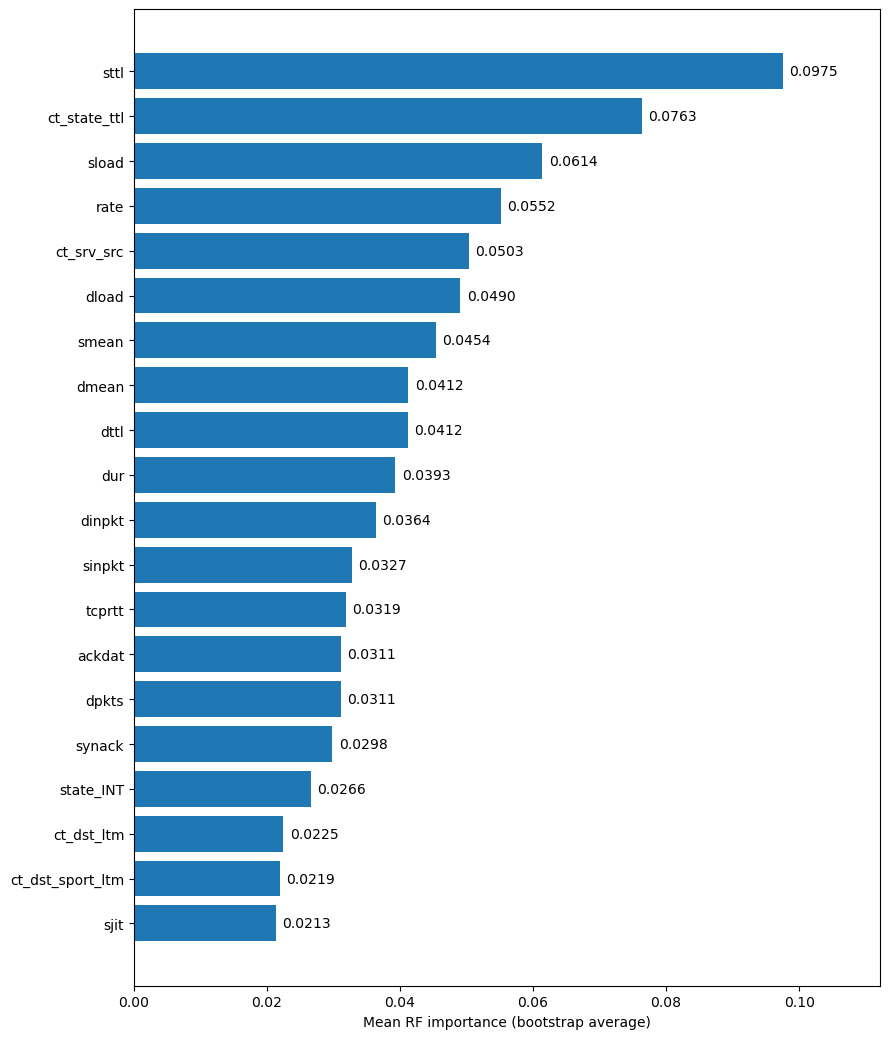

In [14]:
# Take the first 20 features (in descending order of average importance; 
# when the importance is the same, in ascending order of average rank)
topn = 20
top_df = (
    feat_rank_df
    .sort_values(['mean_importance', 'mean_rank'], ascending=[False, True])
    .head(topn)
    # To display the horizontal bar chart from top to bottom in descending order
    .iloc[::-1]  
)

os.makedirs('figures', exist_ok=True)
plt.figure(figsize=(9, 0.45*topn + 1.5))

ypos = np.arange(len(top_df))
vals = top_df['mean_importance'].values
labels = top_df['feature'].values

plt.barh(ypos, vals)
plt.yticks(ypos, labels)
plt.xlabel('Mean RF importance (bootstrap average)')
## plt.title(f'Random Forest Feature Importances (Top {topn})  |  Rank stability (Spearman mean) = {rank_stability:.3f}')

xmax = vals.max() if len(vals) else 1.0
for i, v in enumerate(vals):
    plt.text(v + xmax*0.01, i, f'{v:.4f}', va='center')

plt.xlim(0, xmax*1.15)
plt.tight_layout()

In [15]:
# Automatically search threshold by target precision/recall
def pick_threshold_for_target_precision(y_true, y_score, target_p=0.98):
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    # Align to the length of thresholds
    prec = prec[:-1]
    rec = rec[:-1]
    # Select the threshold with highest recall among those meeting target precision
    mask = prec >= target_p
    if mask.any():
        idx = np.argmax(rec[mask])
        return float(thr[mask][idx]), float(prec[mask][idx]), float(rec[mask][idx])
    # Otherwise, fallback: pick the threshold with highest F1 score on a grid
    grid = np.linspace(0.01, 0.99, 99)
    f1s = [f1_score(y_true, (y_score >= t).astype(int)) for t in grid]
    t = float(grid[int(np.argmax(f1s))])
    return t, None, None

# RF
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(Xtr_bal_sel, ytr_bal)  # Use optimized training set

val_scores = rf.predict_proba(Xval_sel)[:,1]
t98, p98, r98 = pick_threshold_for_target_precision(yval, val_scores, target_p=0.98)
print("VAL threshold at target precision 98% =", t98, "(val approx. Precision/Recall =", round(p98, 4), round(r98, 4), ")")

VAL threshold at target precision 98% = 0.6615476190476189 (val approx. Precision/Recall = 0.9807 0.9329 )


=== Test Set Evaluation (threshold=0.6615) ===
              precision    recall  f1-score   support

           0     0.9018    0.8608    0.8808     37000
           1     0.8904    0.9235    0.9067     45332

    accuracy                         0.8953     82332
   macro avg     0.8961    0.8922    0.8938     82332
weighted avg     0.8956    0.8953    0.8951     82332

Confusion matrix (test):
 [[31849  5151]
 [ 3467 41865]]


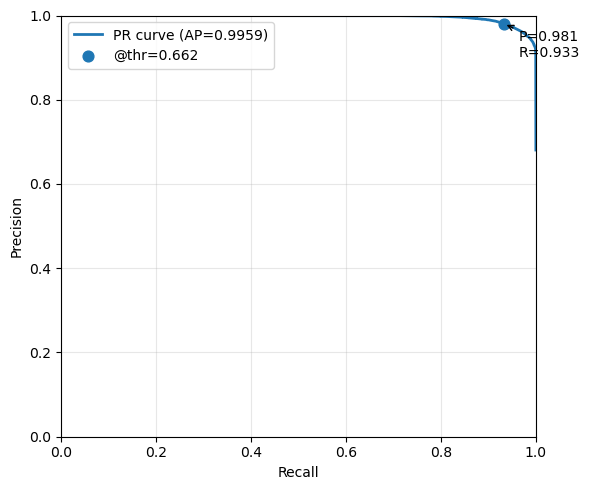

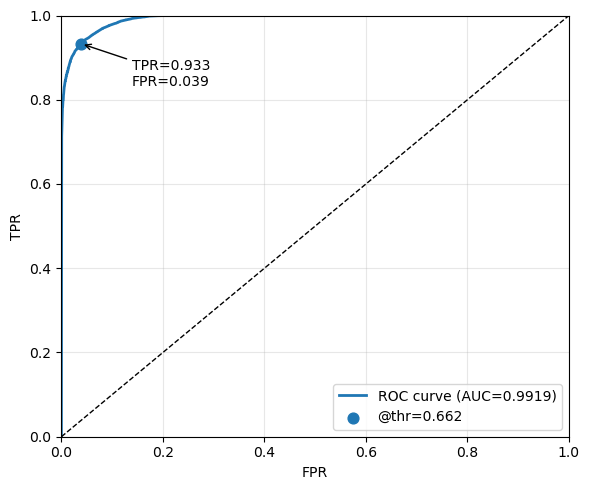

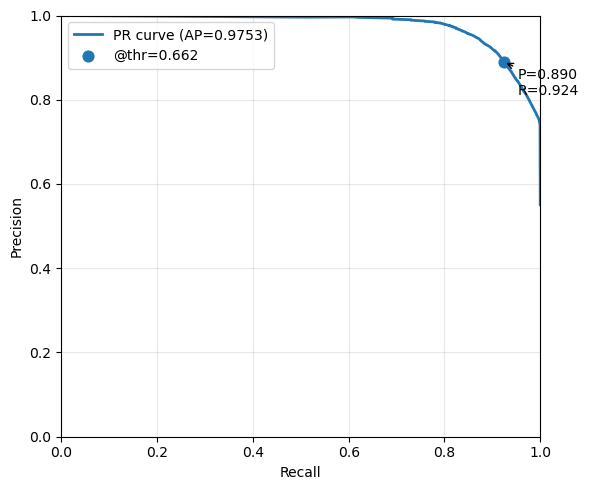

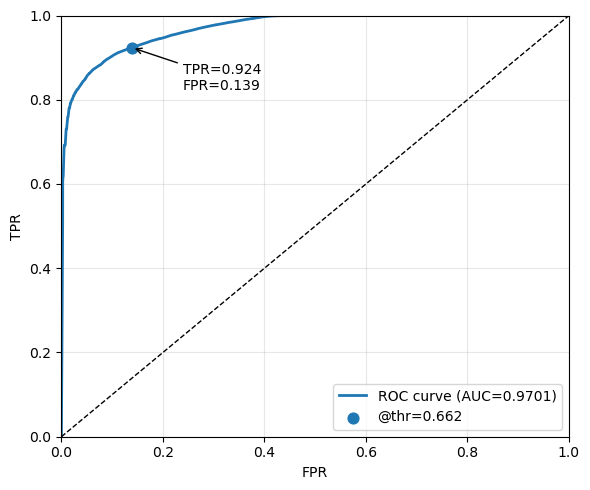

In [16]:
# Reuse threshold on test set for evaluation
test_scores = rf.predict_proba(X_test_fe_sel)[:,1]
y_pred = (test_scores >= t98).astype(int)

print("=== Test Set Evaluation (threshold=%.4f) ===" % t98)
print(classification_report(y_test_np, y_pred, digits=4))
print("Confusion matrix (test):\n", confusion_matrix(y_test_np, y_pred))

# PR & ROC curve plotting utilities ===
def plot_pr_with_point(y_true, y_score, t, title):
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    # The thresholds array in PR has length one less than prec/rec; align and find point near t
    prec_t, rec_t = None, None
    if len(thr) > 0:
        # Find the index of the threshold closest to t
        idx = np.argmin(np.abs(thr - t))
        prec_t = prec[:-1][idx]
        rec_t = rec[:-1][idx]

    plt.figure(figsize=(6,5))
    plt.plot(rec, prec, lw=2, label=f'PR curve (AP={ap:.4f})')
    if prec_t is not None and rec_t is not None:
        plt.scatter([rec_t], [prec_t], s=60, marker='o', label=f'@thr={t:.3f}')
        plt.annotate(f'P={prec_t:.3f}\nR={rec_t:.3f}',
                     xy=(rec_t, prec_t), xytext=(rec_t+0.03, prec_t-0.08),
                     arrowprops=dict(arrowstyle='->', lw=1))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('Recall'); plt.ylabel('Precision')
    ## plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_roc_with_point(y_true, y_score, t, title):
    fpr, tpr, thr = roc_curve(y_true, y_score)
    roc = auc(fpr, tpr)
    # Find the index of the threshold closest to t
    idx = np.argmin(np.abs(thr - t))
    fpr_t = fpr[idx] if idx < len(fpr) else None
    tpr_t = tpr[idx] if idx < len(tpr) else None

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC={roc:.4f})')
    plt.plot([0,1], [0,1], 'k--', lw=1)
    if fpr_t is not None and tpr_t is not None:
        plt.scatter([fpr_t], [tpr_t], s=60, marker='o', label=f'@thr={t:.3f}')
        plt.annotate(f'TPR={tpr_t:.3f}\nFPR={fpr_t:.3f}',
                     xy=(fpr_t, tpr_t), xytext=(min(fpr_t+0.1,0.98), max(tpr_t-0.1,0.05)),
                     arrowprops=dict(arrowstyle='->', lw=1))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR'); plt.ylabel('TPR')
    ## plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Validation set curves (to review where t98 was chosen)
plot_pr_with_point(yval, val_scores, t98, title='Validation PR curve (with operating point)')
plot_roc_with_point(yval, val_scores, t98, title='Validation ROC curve (with operating point)')

# Test set curves (reuse same threshold for test set)
plot_pr_with_point(y_test_np, test_scores, t98, title='Test PR curve (with operating point)')
plot_roc_with_point(y_test_np, test_scores, t98, title='Test ROC curve (with operating point)')

In [17]:
def build_test_frame(X_test_sel, y_test_np, y_pred, test_scores):
    # Use optimized feature subset and column names
    df = pd.DataFrame(X_test_sel, columns=selected_features)
    df['label'] = y_test_np
    df['pred'] = y_pred
    df['score'] = test_scores
    return df

def plot_fp_tn_categorical(df_test_full, col, topk=10, kind='group', return_table=False):
    """
    Plot the distribution comparison of a categorical feature in FP vs TN.
    kind: 'group' for grouped bar; 'stack' for percentage stacked.
    return_table=True returns a DataFrame (proportions) for reporting.
    """
    assert kind in ('group', 'stack')
    # Split FP / TN
    fp = df_test_full[(df_test_full['label'] == 0) & (df_test_full['pred'] == 1)]
    tn = df_test_full[(df_test_full['label'] == 0) & (df_test_full['pred'] == 0)]
    topk_idx = df_test_full[col].value_counts().nlargest(topk).index
    fp_prop = fp[col].value_counts(normalize=True).reindex(topk_idx, fill_value=0)
    tn_prop = tn[col].value_counts(normalize=True).reindex(topk_idx, fill_value=0)
    tbl = pd.DataFrame({'FP': fp_prop, 'TN': tn_prop}).reset_index().rename(columns={'index': col})

    if kind == 'group':
        long = tbl.melt(id_vars=col, var_name='Type', value_name='Proportion')
        plt.figure(figsize=(9, 5))
        sns.barplot(data=long, x=col, y='Proportion', hue='Type')
        ## plt.title(f"{col} Distribution Comparison (FP vs TN)")
        plt.ylabel("Proportion")
        plt.xlabel(col)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:  # stack
        stack_df = tbl.set_index(col) * 100
        ax = stack_df.plot(kind='bar', stacked=True, figsize=(10, 5))
        ax.set_ylabel('Percentage (%)')
        ## ax.set_title(f"{col} — FP vs TN Percentage Stacked Chart")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    return tbl if return_table else None

def fp_tn_numeric_compare(df_test_full, num_cols):
    """
    Compare mean/median of numeric features in FP vs TN.
    Returns a DataFrame for identifying features with large differences.
    """
    fp = df_test_full[(df_test_full['label'] == 0) & (df_test_full['pred'] == 1)]
    tn = df_test_full[(df_test_full['label'] == 0) & (df_test_full['pred'] == 0)]
    rows = []
    for c in num_cols:
        rows.append({
            'feature': c,
            'FP_mean':   fp[c].mean(),
            'TN_mean':   tn[c].mean(),
            'FP_median': fp[c].median(),
            'TN_median': tn[c].median(),
            'FP_q90':    fp[c].quantile(0.90),
            'TN_q90':    tn[c].quantile(0.90)
        })
    out = pd.DataFrame(rows)
    out['mean_gap'] = out['FP_mean'] - out['TN_mean']
    out['median_gap'] = out['FP_median'] - out['TN_median']
    return out.sort_values('mean_gap', ascending=False)

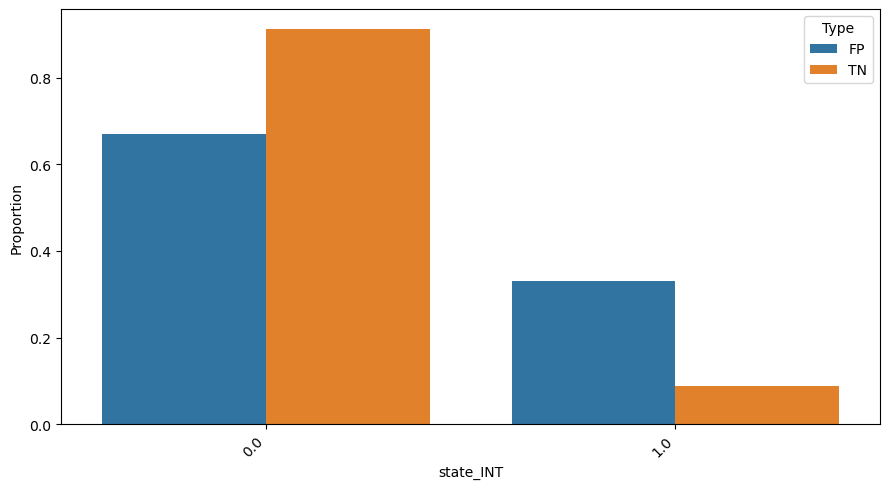

  feature   FP_mean   TN_mean  FP_median  TN_median    FP_q90    TN_q90  \
2    sttl -0.096098 -0.769117   0.000000  -1.161458  0.000000  0.000000   
0     dur  1.123008  0.701690   1.049791   0.263110  2.281340  1.572552   
3    dttl  0.551005  0.277129   0.884921   0.000000  0.884921  0.884921   
1    rate -0.260107 -0.276231  -0.571860  -0.341677  0.502290  0.109920   

   mean_gap  median_gap  
2  0.673019    1.161458  
0  0.421318    0.786681  
3  0.273876    0.884921  
1  0.016124   -0.230183  


In [18]:
# Build df_test_full (keep this line unchanged)
df_test_full = build_test_frame(X_test_fe_sel, y_test_np, y_pred, test_scores)

# Plot only for categorical columns that exist
for col, kind in [('state_INT', 'group')]:
    if col in df_test_full.columns:
        plot_fp_tn_categorical(df_test_full, col, topk=10, kind=kind)
    else:
        print(f"[skip] Column does not exist: {col}")

# Numeric feature comparison: keep only existing columns
num_cols_all = ['dur', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sloss', 'dloss']
num_cols = [c for c in num_cols_all if c in df_test_full.columns]
if len(num_cols):
    gap_tbl = fp_tn_numeric_compare(df_test_full, num_cols)
    print(gap_tbl.head(10))
else:
    print("[skip] No numeric columns found in the current feature subset")

# BNN

[Epoch 01] ELBO per-sample = 10.672424
[Epoch 02] ELBO per-sample = 10.146330
[Epoch 03] ELBO per-sample = 9.791298
[Epoch 04] ELBO per-sample = 9.496363
[Epoch 05] ELBO per-sample = 9.173069
[Epoch 06] ELBO per-sample = 8.850053
[Epoch 07] ELBO per-sample = 8.531185
[Epoch 08] ELBO per-sample = 8.231204
[Epoch 09] ELBO per-sample = 7.918302
[Epoch 10] ELBO per-sample = 7.604945
[Epoch 11] ELBO per-sample = 7.304998
[Epoch 12] ELBO per-sample = 7.016198
[Epoch 13] ELBO per-sample = 6.726262
[Epoch 14] ELBO per-sample = 6.429908
[Epoch 15] ELBO per-sample = 6.152098
[Epoch 16] ELBO per-sample = 5.887051
[Epoch 17] ELBO per-sample = 5.622633
[Epoch 18] ELBO per-sample = 5.374128
[Epoch 19] ELBO per-sample = 5.126600
[Epoch 20] ELBO per-sample = 4.897644
[Epoch 21] ELBO per-sample = 4.669963
[Epoch 22] ELBO per-sample = 4.472880
[Epoch 23] ELBO per-sample = 4.259700
[Epoch 24] ELBO per-sample = 4.074600
[Epoch 25] ELBO per-sample = 3.898638
[Epoch 26] ELBO per-sample = 3.749448
[Epoch 27]

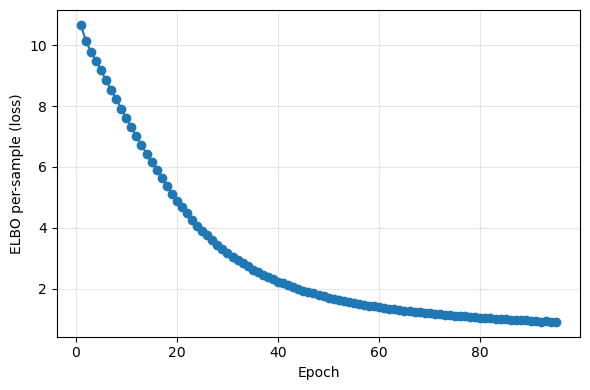

/var/folders/sd/npzgh51x7ml42xkpxjj1gcj80000gn/T/ipykernel_19337/2294420163.py:82: RuntimeWarning: divide by zero encountered in log
  y_entropy = -(p_ * np.log(p_) + (1-p_) * np.log(1-p_))
/var/folders/sd/npzgh51x7ml42xkpxjj1gcj80000gn/T/ipykernel_19337/2294420163.py:82: RuntimeWarning: invalid value encountered in multiply
  y_entropy = -(p_ * np.log(p_) + (1-p_) * np.log(1-p_))



[BNN] TEST (fixed t98) -> {'roc_auc': 0.9514, 'pr_auc': 0.9624, 'precision': 0.9021, 'recall': 0.8501, 'f1': 0.8753, 'threshold': 0.6615, 'brier': 0.1008}
Confusion matrix (test, t98):
 [[32819  4181]
 [ 6795 38537]]

[BNN] TEST (BNN-opt threshold on VAL) -> {'roc_auc': 0.9514, 'pr_auc': 0.9624, 'precision': 0.7549, 'recall': 0.982, 'f1': 0.8536, 'threshold': 0.46, 'brier': 0.1008}
Confusion matrix (test, BNN-opt):
 [[22550 14450]
 [  818 44514]]


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Xtr_t = torch.from_numpy(Xtr_bal_sel.astype(np.float32)).to(device)
ytr_t = torch.from_numpy(ytr_bal.astype(np.float32)).to(device)
Xte_t = torch.from_numpy(X_test_fe_sel.astype(np.float32)).to(device)
# Keep as numpy for evaluation
yte = y_test_np

train_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=2048, shuffle=True, drop_last=False)

# Model definition
class BayesianNN(PyroModule):
    def __init__(self, in_features, h1=128, h2=64):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](in_features, h1)
        self.fc1.weight = PyroSample(dist.Normal(0.,1.).expand([h1, in_features]).to_event(2))
        self.fc1.bias   = PyroSample(dist.Normal(0.,1.).expand([h1]).to_event(1))

        self.fc2 = PyroModule[nn.Linear](h1, h2)
        self.fc2.weight = PyroSample(dist.Normal(0.,1.).expand([h2, h1]).to_event(2))
        self.fc2.bias   = PyroSample(dist.Normal(0.,1.).expand([h2]).to_event(1))

        self.out = PyroModule[nn.Linear](h2, 1)
        self.out.weight = PyroSample(dist.Normal(0.,1.).expand([1, h2]).to_event(2))
        self.out.bias   = PyroSample(dist.Normal(0.,1.).expand([1]).to_event(1))

    def forward(self, x, y=None):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.out(x).squeeze(-1)
        with pyro.plate("data", size=logits.shape[0]):
            pyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)
        return logits

# Training
pyro.clear_param_store()
bnn = BayesianNN(Xtr_t.shape[1]).to(device)
guide = AutoDiagonalNormal(bnn)
svi = SVI(model=bnn, guide=guide, optim=Adam({"lr": 1e-3}), loss=Trace_ELBO())


elbo_hist = []
min_rel_improve = 0.03 
# last 5 epochs
window = 5

for ep in range(1, 201):
    total_loss = 0.0
    for xb, yb in train_loader:
        total_loss += svi.step(xb, yb)
    elbo_per_sample = total_loss / len(Xtr_t)   # negative ELBO (loss)
    elbo_hist.append(elbo_per_sample)
    print(f"[Epoch {ep:02d}] ELBO per-sample = {elbo_per_sample:.6f}")

    # --- early stopping
    if len(elbo_hist) >= window + 1:
        start_val = elbo_hist[-window-1]
        cur_val = elbo_hist[-1]
        rel = (start_val - cur_val) / max(abs(start_val), 1e-12)
        if rel < min_rel_improve:
            print(f"[Early Stop] Cumulative improvement over last {window} epochs "
                  f"{rel*100:.2f}% < {min_rel_improve*100:.0f}%. Stop at epoch {ep}.")
            break

plt.figure(figsize=(6,4))
plt.plot(range(1, len(elbo_hist)+1), elbo_hist, marker='o')
plt.xlabel("Epoch")
plt.ylabel("ELBO per-sample (loss)")
## plt.title("ELBO per-sample over epochs")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Prediction (posterior sampling)
predictive = Predictive(bnn, guide=guide, num_samples=200, return_sites=["obs"])
with torch.no_grad():
    obs_te = predictive(Xte_t)["obs"].float()

# Probability and uncertainty
y_prob = obs_te.mean(dim=0).cpu().numpy()
y_var = obs_te.var(dim=0).cpu().numpy()
p_ = np.clip(y_prob, 1e-12, 1-1e-12)
y_entropy = -(p_ * np.log(p_) + (1-p_) * np.log(1-p_))

# Evaluation utilities
def eval_with_threshold(y_true, y_score, threshold=None):
    roc = roc_auc_score(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    if threshold is None:
        grid = np.linspace(0.01, 0.99, 99)
        f1s = [f1_score(y_true, (y_score >= t).astype(int)) for t in grid]
        threshold = float(grid[int(np.argmax(f1s))])
    y_pred = (y_score >= threshold).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    brier = brier_score_loss(y_true, y_score)
    return {'roc_auc': roc, 'pr_auc': ap, 'precision': prec, 'recall': rec, 'f1': f1,
            'threshold': threshold, 'cm': cm, 'brier': brier, 'y_pred': y_pred}

def pick_f1_threshold_on(y_true, y_score):
    grid = np.linspace(0.01, 0.99, 99)
    f1s = [f1_score(y_true, (y_score >= t).astype(int)) for t in grid]
    return float(grid[int(np.argmax(f1s))])

# Fixed t98 threshold
try:
    t_use = float(t98)
    m_fixed = eval_with_threshold(yte, y_prob, threshold=t_use)
    print("\n[BNN] TEST (fixed t98) ->", {k:(round(v,4) if isinstance(v,float) else v)
                                          for k,v in m_fixed.items() if k not in ['cm','y_pred']})
    print("Confusion matrix (test, t98):\n", m_fixed['cm'])
except NameError:
    print("\nt98 variable not detected, skipping fixed t98 evaluation.")

# BNN's own optimal threshold
# Prefer to find threshold on validation set
use_test_for_thr = False
try:
    # If Xval / yval is available, use BNN to score the validation set
    Xval_t = torch.from_numpy(Xval_sel.astype(np.float32)).to(device)
    with torch.no_grad():
        obs_val = predictive(Xval_t)["obs"].float()
    y_prob_val = obs_val.mean(dim=0).cpu().numpy()
    t_bnn = pick_f1_threshold_on(yval, y_prob_val)
    t_bnn_opt = float(t_bnn)
except Exception:
    t_bnn = pick_f1_threshold_on(yte, y_prob)
    t_bnn_opt = float(t_bnn)
    use_test_for_thr = True

m_best = eval_with_threshold(yte, y_prob, threshold=t_bnn)
print("\n[BNN] TEST (BNN-opt threshold{}) ->".format(" on TEST" if use_test_for_thr else " on VAL"),
      {k:(round(v,4) if isinstance(v,float) else v) for k,v in m_best.items() if k not in ['cm','y_pred']})
print("Confusion matrix (test, BNN-opt):\n", m_best['cm'])

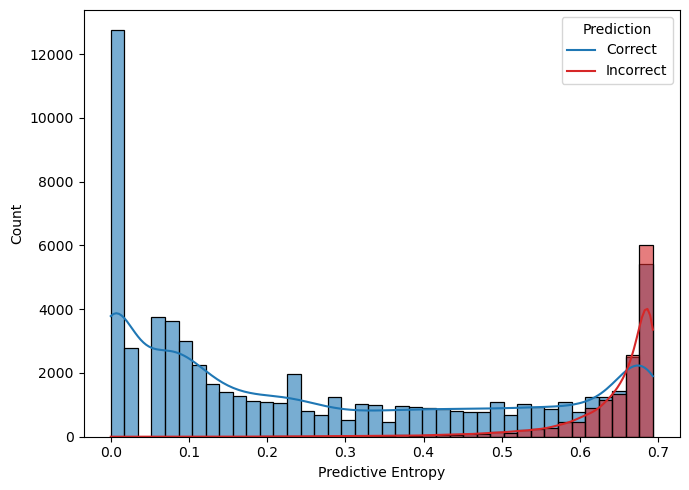

In [20]:
# Predicted labels (can change threshold from 0.5 to t98 or t_bnn)
y_pred = (y_prob >= 0.5).astype(int)
correct_mask = (y_pred == yte)

# Compute predictive entropy
eps = 1e-12
entropy = -y_prob * np.log(y_prob + eps) - (1 - y_prob) * np.log(1 - y_prob + eps)

# Combine into DataFrame
df_entropy = pd.DataFrame({
    "Entropy": entropy,
    "Prediction": np.where(correct_mask, "Correct", "Incorrect")
})

# Plot histogram
plt.figure(figsize=(7,5))
sns.histplot(
    data=df_entropy, 
    x="Entropy", 
    hue="Prediction", 
    bins=40, 
    kde=True, 
    palette={"Correct": "tab:blue", "Incorrect": "tab:red"},
    alpha=0.6
)
plt.xlabel("Predictive Entropy")
plt.ylabel("Count")
## plt.title("Predictive Entropy by Prediction Correctness (BNN)")
plt.legend(title="Prediction", labels=["Correct", "Incorrect"])
plt.tight_layout()
plt.show()

In [21]:
# Uncertainty stratification
hi, lo = np.quantile(y_entropy, [0.9, 0.1])
tiers = np.where(y_entropy >= hi, "High-U",
         np.where(y_entropy <= lo, "Low-U", "Mid-U"))
err = ((y_prob >= m_best['threshold']).astype(int) != yte).astype(int)
unc_report = pd.DataFrame({'unc_tier': tiers, 'err': err})
print("\nError rate by uncertainty tier:")
print(unc_report.groupby('unc_tier')['err'].mean().sort_index())


Error rate by uncertainty tier:
unc_tier
Mid-U    0.185444
Name: err, dtype: float64


In [22]:
def _nearest_idx(arr, v):
    """
    Return the index in a 1D numpy array `arr` whose value is closest to `v`
    """
    return int(np.argmin(np.abs(arr - v)))

def summarize_at_threshold(y_true, y_score, thr):
    """
    Return metrics at threshold `thr`: P/R/F1/TPR/FPR/support, and PR-point (precision/recall)
    """
    y_pred = (y_score >= thr).astype(int)
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

    # ROC point
    fpr, tpr, roc_thr = roc_curve(y_true, y_score)
    ridx = _nearest_idx(roc_thr, thr)
    tpr_v = tpr[ridx] if ridx < len(tpr) else None
    fpr_v = fpr[ridx] if ridx < len(fpr) else None

    # PR point (note: `pr_thr` has length one less than `prec/rec`)
    prec, rec, pr_thr = precision_recall_curve(y_true, y_score)
    pidx = _nearest_idx(pr_thr, thr) if len(pr_thr) else None
    prec_v = (prec[:-1][pidx] if pidx is not None and pidx < len(prec[:-1]) else None)
    rec_v  = (rec[:-1][pidx]  if pidx is not None and pidx < len(rec[:-1])  else None)

    return {
        "precision": report["1"]["precision"],
        "recall": report["1"]["recall"],
        "f1": report["1"]["f1-score"],
        "support_pos": report["1"]["support"],
        "tpr": tpr_v, "fpr": fpr_v,
        "pr_precision": prec_v, "pr_recall": rec_v
    }

def plot_roc_pr_with_points(y_true, y_score, points, title_prefix=""):
    """
    Plot ROC and PR curves and mark specified operating points.

    Parameters
    ----------
    y_true : np.ndarray
        Ground-truth binary labels for the test set (shape: [n_samples]).
    y_score : np.ndarray
        Predicted probabilities (shape: [n_samples]).
    points : list[tuple[str, float]]
        List of (label, threshold) pairs, e.g., [("t98", t98), ("BNN-opt", t_bnn)].
    title_prefix : str
        Optional prefix for subplot titles.
    """
    # ROC
    fpr, tpr, roc_thr = roc_curve(y_true, y_score)
    roc_auc_val = auc(fpr, tpr)

    # PR (note: `pr_thr` has length one less than `prec/rec`)
    prec, rec, pr_thr = precision_recall_curve(y_true, y_score)
    pr_auc_val = auc(rec, prec)

    plt.figure(figsize=(14, 5))

    # ---- ROC subplot ----
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, lw=2, label=f'ROC AUC = {roc_auc_val:.4f}')
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    for name, t in points:
        idx = _nearest_idx(roc_thr, t)
        x = fpr[idx] if idx < len(fpr) else None
        y = tpr[idx] if idx < len(tpr) else None
        if x is not None and y is not None:
            plt.scatter([x], [y], marker='o', s=60, label=f'{name} (thr={t:.3f})')
            plt.annotate(f'TPR={y:.3f}\nFPR={x:.3f}', xy=(x, y),
                         xytext=(min(x + 0.12, 0.98), max(y - 0.12, 0.05)),
                         arrowprops=dict(arrowstyle='->', lw=1))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    ## plt.title(f'{title_prefix} ROC Curve')
    plt.legend()
    plt.grid(alpha=0.3)

    # ---- PR subplot ----
    plt.subplot(1, 2, 2)
    plt.plot(rec, prec, lw=2, label=f'PR AUC = {pr_auc_val:.4f}')
    for name, t in points:
        if len(pr_thr):
            idx = _nearest_idx(pr_thr, t)
            x = rec[:-1][idx] if idx < len(rec[:-1]) else None
            y = prec[:-1][idx] if idx < len(prec[:-1]) else None
            if x is not None and y is not None:
                plt.scatter([x], [y], marker='o', s=60, label=f'{name} (thr={t:.3f})')
                plt.annotate(f'P={y:.3f}\nR={x:.3f}', xy=(x, y),
                             xytext=(min(x + 0.08, 0.98), max(y - 0.12, 0.05)),
                             arrowprops=dict(arrowstyle='->', lw=1))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    ## plt.title(f'{title_prefix} Precision-Recall Curve')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

def print_points_summary(y_true, y_score, points):
    """
    Print detailed metrics at each threshold point (P/R/F1/TPR/FPR/PR point/support)
    """
    for name, t in points:
        s = summarize_at_threshold(y_true, y_score, t)
        print(f"[{name} @ thr={t:.4f}] "
              f"Precision={s['precision']:.4f}, Recall={s['recall']:.4f}, F1={s['f1']:.4f} | "
              f"TPR={s['tpr']:.4f}, FPR={s['fpr']:.4f} | "
              f"PR-pt: P={s['pr_precision']:.4f}, R={s['pr_recall']:.4f}  (pos={int(s['support_pos'])})")

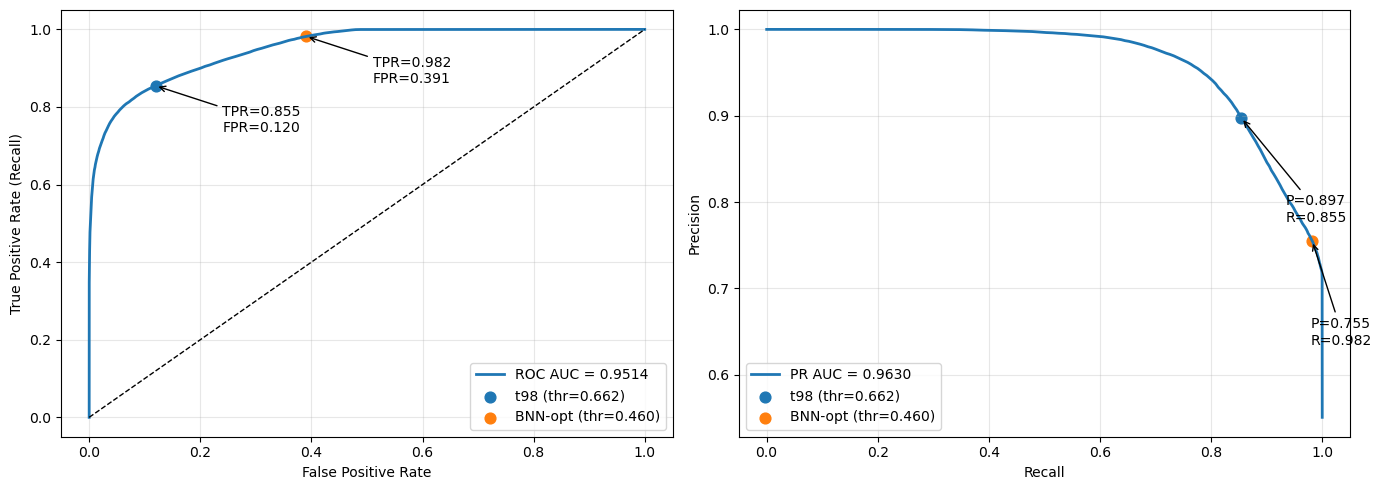

[t98 @ thr=0.6615] Precision=0.9021, Recall=0.8501, F1=0.8753 | TPR=0.8546, FPR=0.1198 | PR-pt: P=0.8973, R=0.8546  (pos=45332)
[BNN-opt @ thr=0.4600] Precision=0.7549, Recall=0.9820, F1=0.8536 | TPR=0.9820, FPR=0.3905 | PR-pt: P=0.7549, R=0.9820  (pos=45332)


In [23]:
# For BNN probabilities
points_bnn = []
try:
    points_bnn.append(("t98", float(t98)))
except NameError:
    pass
try:
    points_bnn.append(("BNN-opt", float(t_bnn)))
except NameError:
    pass

plot_roc_pr_with_points(y_test_np, y_prob, points_bnn, title_prefix="BNN")
print_points_summary(y_test_np, y_prob, points_bnn)

### Comparison of Unsupervised Methods (LOF & DBSCAN)

In [24]:
# Unsupervised baselines: LOF & DBSCAN (standalone runnable)
def _get_y_true():
    if 'y_test' in globals():
        try:
            return np.asarray(y_test)
        except Exception:
            pass
    if 'y_test_np' in globals():
        return np.asarray(y_test_np)
    return None

def evaluate_scores(y_true, scores, name="MODEL"):
    """
    Higher `scores` = more anomalous
    """
    if y_true is None:
        print(f"[{name}] No labels provided. Returning anomaly scores (higher = more anomalous).")
        return {"scores": scores}
    ap = average_precision_score(y_true, scores)
    try:
        auc_val = roc_auc_score(y_true, scores)
    except Exception:
        auc_val = float("nan")
    prec, rec, thr = precision_recall_curve(y_true, scores, pos_label=1)
    f1s = 2 * prec * rec / (prec + rec + 1e-12)
    best_idx = f1s.argmax()
    best_thr = (thr[best_idx - 1] if best_idx > 0 and best_idx - 1 < len(thr) else None)
    print(f"[{name}]  AP={ap:.4f}  ROC-AUC={auc_val:.4f}  F1@bestPR={f1s[best_idx]:.4f}  "
          f"Precision={prec[best_idx]:.4f}  Recall={rec[best_idx]:.4f}")
    return {
        "AP": ap, "ROC-AUC": auc_val,
        "F1@bestPR": f1s[best_idx],
        "Precision@bestPR": prec[best_idx],
        "Recall@bestPR": rec[best_idx],
        "thr": best_thr,
        "scores": scores
    }

Xtr = np.asarray(Xtr_bal_sel, dtype=np.float32)
Xte = np.asarray(X_test_fe_sel, dtype=np.float32)

# LOF (novelty mode)
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=50, contamination="auto", novelty=True)
lof.fit(Xtr)
# higher = more anomalous
lof_scores = -lof.decision_function(Xte)  
res_lof = evaluate_scores(_get_y_true(), lof_scores, name="LOF")

# DBSCAN
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=1.5, min_samples=20).fit(Xtr) 

from sklearn.neighbors import NearestNeighbors
core_samples = db.components_ if hasattr(db, "components_") and db.components_.size else Xtr
nbrs = NearestNeighbors(n_neighbors=1).fit(core_samples)
dists, _ = nbrs.kneighbors(Xte)
# higher = more anomalous
dbscan_scores = dists.ravel()
res_dbscan = evaluate_scores(_get_y_true(), dbscan_scores, name="DBSCAN-NN")

lof_anomaly_scores = res_lof.get("scores", lof_scores)
dbscan_anomaly_scores = res_dbscan.get("scores", dbscan_scores)

[LOF]  AP=0.6805  ROC-AUC=0.6018  F1@bestPR=0.7104  Precision=0.5509  Recall=1.0000
[DBSCAN-NN]  AP=0.5424  ROC-AUC=0.4653  F1@bestPR=0.7102  Precision=0.5506  Recall=1.0000


### AE & VAE


In [25]:
# AutoEncoder
input_dim = Xtr.shape[1]

# AE model
ae_input = keras.Input(shape=(input_dim,))
encoded = layers.Dense(64, activation='relu')(ae_input)
encoded = layers.Dense(32, activation='relu')(encoded)
decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(input_dim, activation=None)(decoded)

ae_model = keras.Model(ae_input, decoded)
ae_model.compile(optimizer='adam', loss='mse')

# Train AE
ae_model.fit(Xtr, Xtr, epochs=50, batch_size=256, shuffle=True,
             validation_data=(Xte, Xte), verbose=0)

# AE anomaly score = reconstruction error
ae_recon = ae_model.predict(Xte, verbose=0)
ae_scores = np.mean(np.square(Xte - ae_recon), axis=1)
res_ae = evaluate_scores(_get_y_true(), ae_scores, name="AE")


# Variational AutoEncoder
latent_dim = 16

vae_input = keras.Input(shape=(input_dim,))
h = layers.Dense(64, activation='relu')(vae_input)
h = layers.Dense(32, activation='relu')(h)
z_mean = layers.Dense(latent_dim)(h)
z_log_var = layers.Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * eps

z = layers.Lambda(sampling)([z_mean, z_log_var])
encoder = keras.Model(vae_input, [z_mean, z_log_var, z], name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
h_dec = layers.Dense(32, activation='relu')(latent_inputs)
h_dec = layers.Dense(64, activation='relu')(h_dec)
out_dec = layers.Dense(input_dim)(h_dec)
decoder = keras.Model(latent_inputs, out_dec, name="decoder")

# VAE class
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            recon = self.decoder(z)
            recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - recon), axis=1))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            total_loss = recon_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Train VAE
vae_model = VAE(encoder, decoder)
vae_model.compile(optimizer=keras.optimizers.Adam(),
                  loss=lambda y_true, y_pred: 0.0)
vae_model.fit(Xtr, Xtr,
              epochs=50, batch_size=256, shuffle=True,
              validation_data=(Xte, Xte), verbose=0)

# VAE anomaly score = reconstruction error
vae_recon = vae_model.predict(Xte, verbose=0)
vae_scores = np.mean(np.square(Xte - vae_recon), axis=1)
res_vae = evaluate_scores(_get_y_true(), vae_scores, name="VAE")

# Expose AE/VAE scores for later steps (consistent with LOF/DBSCAN naming)
ae_anomaly_scores  = res_ae.get("scores", ae_scores)
vae_anomaly_scores = res_vae.get("scores", vae_scores)

[AE]  AP=0.4990  ROC-AUC=0.4316  F1@bestPR=0.7156  Precision=0.5612  Recall=0.9872
[VAE]  AP=0.5117  ROC-AUC=0.4098  F1@bestPR=0.7102  Precision=0.5506  Recall=1.0000


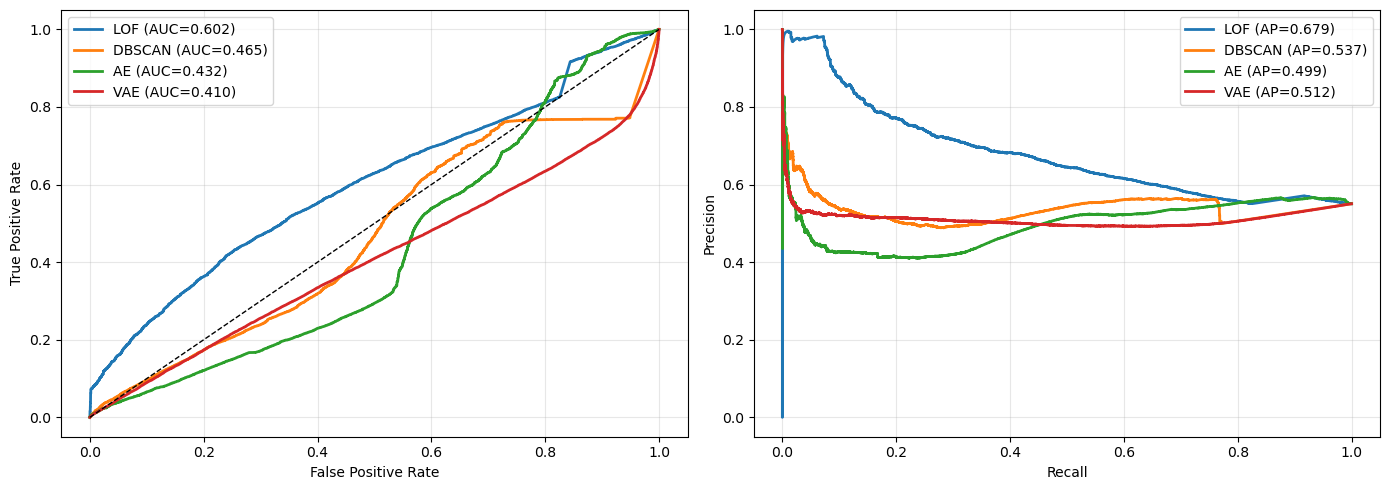

In [32]:
# LOF vs DBSCAN vs AE vs VAE
def plot_roc_pr_comparison(y_true, scores_dict, title_suffix=""):
    """
    Plot ROC & PR curves for multiple methods
    """
    plt.figure(figsize=(14,5))

    # ---- ROC subplot ----
    plt.subplot(1, 2, 1)
    for name, scores in scores_dict.items():
        fpr, tpr, _ = roc_curve(y_true, scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={roc_auc:.3f})")
    plt.plot([0,1],[0,1],'k--', lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    ## plt.title(f"ROC Curve Comparison{(' — ' + title_suffix) if title_suffix else ''}")
    plt.legend()
    plt.grid(alpha=0.3)

    # ---- PR subplot ----
    plt.subplot(1, 2, 2)
    for name, scores in scores_dict.items():
        prec, rec, _ = precision_recall_curve(y_true, scores)
        pr_auc = auc(rec, prec)
        plt.plot(rec, prec, lw=2, label=f"{name} (AP={pr_auc:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    ## plt.title(f"Precision–Recall Curve Comparison{(' — ' + title_suffix) if title_suffix else ''}")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


scores_dict_all = {
    "LOF": lof_anomaly_scores,
    "DBSCAN": dbscan_anomaly_scores,
    "AE": ae_anomaly_scores,
    "VAE": vae_anomaly_scores,
}
plot_roc_pr_comparison(y_test_np, scores_dict_all, title_suffix="Unsupervised Baselines")

In [27]:
# BNN vs Unsupervised
def pr_best_summary(y_true, y_score):
    ap  = average_precision_score(y_true, y_score)
    roc = roc_auc_score(y_true, y_score)
    prec, rec, thr = precision_recall_curve(y_true, y_score, pos_label=1)
    f1s = 2 * prec * rec / (prec + rec + 1e-12)
    idx = int(np.argmax(f1s))
    thr_best = (thr[idx-1] if idx > 0 and idx-1 < len(thr) else np.nan)
    return {"AP": ap, "ROC-AUC": roc, "F1@bestPR": f1s[idx],
            "Precision@bestPR": prec[idx], "Recall@bestPR": rec[idx],
            "thr": thr_best}

def eval_at_fixed_threshold(y_true, y_score, thr):
    ap  = average_precision_score(y_true, y_score)
    roc = roc_auc_score(y_true, y_score)
    y_pred = (y_score >= thr).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='binary', zero_division=0
    )
    return {"AP": ap, "ROC-AUC": roc, "F1@bestPR": f1,
            "Precision@bestPR": prec, "Recall@bestPR": rec,
            "thr": thr}

rows = []

# BNN (Evaluate t_bnn_opt selected by the validation set on the test set)
rows.append({"Model": "BNN-opt", **eval_at_fixed_threshold(y_test_np, y_prob, t_bnn_opt)})

# Unsupervised (from evaluate_scores )
def add_row(res, name):
    if isinstance(res, dict):
        rows.append({
            "Model": name,
            "AP": res.get("AP", np.nan),
            "ROC-AUC": res.get("ROC-AUC", np.nan),
            "F1@bestPR": res.get("F1@bestPR", np.nan),
            "Precision@bestPR": res.get("Precision@bestPR", np.nan),
            "Recall@bestPR": res.get("Recall@bestPR", np.nan),
            "thr": res.get("thr", np.nan)
        })

for name, res in [("LOF", globals().get("res_lof")),
                  ("DBSCAN-NN", globals().get("res_dbscan")),
                  ("AE", globals().get("res_ae")),
                  ("VAE", globals().get("res_vae"))]:
    if res is not None:
        add_row(res, name)

cmp_df = pd.DataFrame(rows)
cmp_df = cmp_df[["Model", "AP", "ROC-AUC", "F1@bestPR", "Precision@bestPR", "Recall@bestPR", "thr"]]
print(cmp_df.sort_values("AP", ascending=False).round(4))

       Model      AP  ROC-AUC  F1@bestPR  Precision@bestPR  Recall@bestPR  \
0    BNN-opt  0.9624   0.9514     0.8536            0.7549         0.9820   
1        LOF  0.6805   0.6018     0.7104            0.5509         1.0000   
2  DBSCAN-NN  0.5424   0.4653     0.7102            0.5506         1.0000   
4        VAE  0.5117   0.4098     0.7102            0.5506         1.0000   
3         AE  0.4990   0.4316     0.7156            0.5612         0.9872   

      thr  
0  0.4600  
1 -0.7165  
2     NaN  
4     NaN  
3  0.0000  


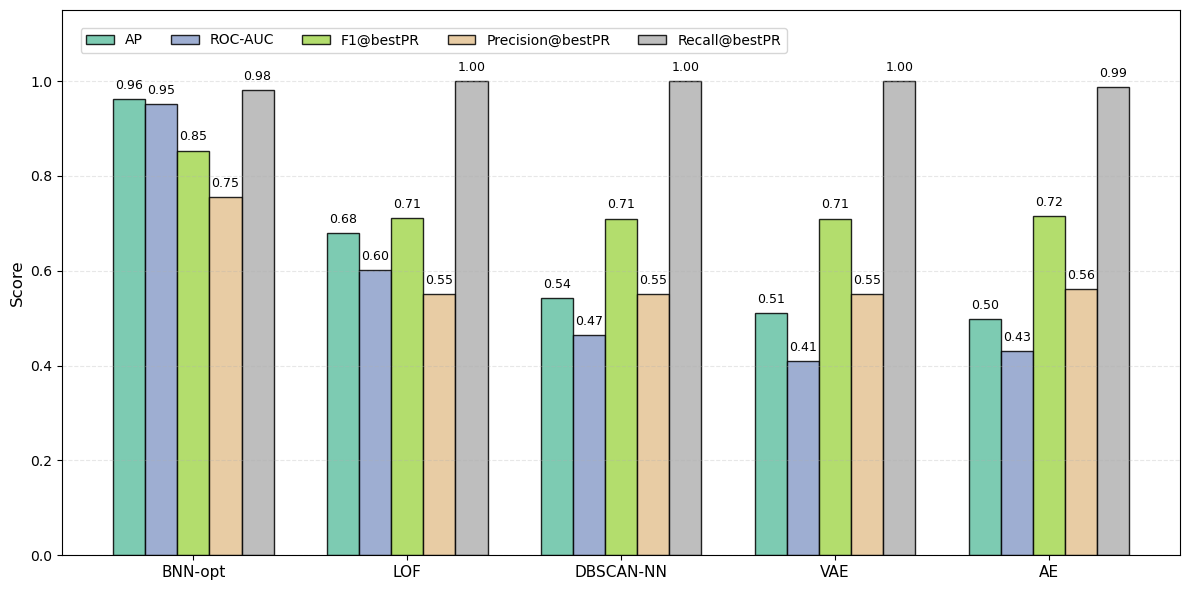

In [28]:
# Metrics and data
metrics = ["AP", "ROC-AUC", "F1@bestPR", "Precision@bestPR", "Recall@bestPR"]
df_plot = cmp_df.copy()
df_plot = df_plot.sort_values("AP", ascending=False).reset_index(drop=True)

models = df_plot["Model"].tolist()
vals = df_plot[metrics].to_numpy()

x = np.arange(len(models))
width = 0.15
colors = plt.cm.Set2(np.linspace(0, 1, len(metrics)))  # Use Set2 color palette

plt.figure(figsize=(12, 6))

# Draw bars with value labels
for i, m in enumerate(metrics):
    plt.bar(x + i * width, vals[:, i], width, label=m, color=colors[i], edgecolor='black', alpha=0.85)
    for j, v in enumerate(vals[:, i]):
        plt.text(x[j] + i * width, v + 0.015, f"{v:.2f}", ha='center', va='bottom', fontsize=9)

# X-axis
plt.xticks(x + width * (len(metrics) - 1) / 2, models, fontsize=11)
plt.ylim(0, 1.15)

# Labels and title
plt.ylabel("Score", fontsize=12)
## plt.title("BNN vs Unsupervised — Metric Comparison", fontsize=14, fontweight='bold')

# Legend: one row, top-left inside
plt.legend(
    ncol=len(metrics),
    fontsize=10,
    frameon=True,
    facecolor='white',
    framealpha=0.8,
    loc='upper left',
    bbox_to_anchor=(0.01, 0.98)
)

plt.grid(axis="y", alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


### ECE

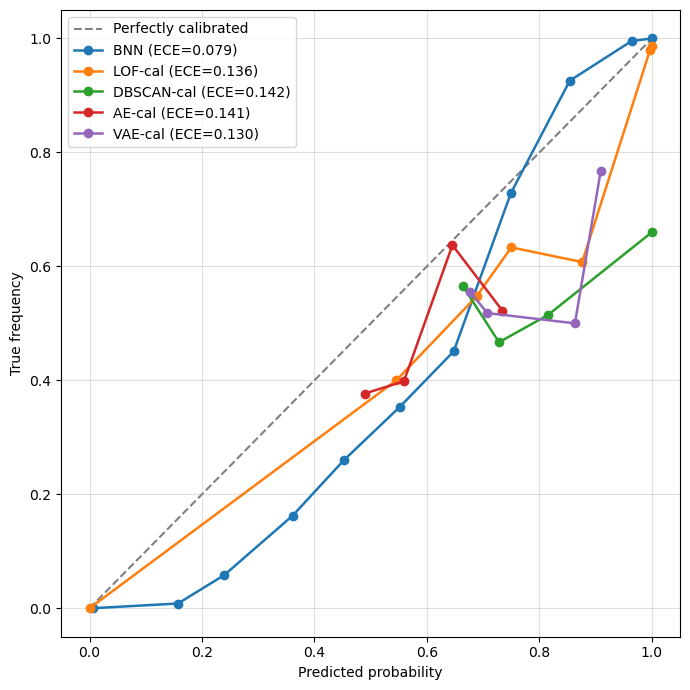

In [29]:
# Probability calibration for unsupervised scores using validation set
Xval = np.asarray(Xval_sel, dtype=np.float32)

# Get scores for each method on the validation set
# LOF
val_lof_scores = -lof.decision_function(Xval)

# DBSCAN
val_dists, _ = nbrs.kneighbors(Xval)
val_dbscan_scores = val_dists.ravel()

# AE
ae_val_recon = ae_model.predict(Xval, verbose=0)
val_ae_scores = np.mean(np.square(Xval - ae_val_recon), axis=1)

# VAE
z_mean_v, z_log_var_v, z_v = vae_model.encoder(Xval)
vae_val_recon = vae_model.decoder(z_v)
val_vae_scores = np.mean(np.square(Xval - vae_val_recon), axis=1)

# Select calibration method
CALIB = "isotonic"

def fit_calibrator(y, s, how="isotonic"):
    if how == "isotonic":
        cal = IsotonicRegression(out_of_bounds="clip")
        cal.fit(s, y)
        return cal
    else:  # Platt scaling = logistic regression on scores
        lr = LogisticRegression(max_iter=2000)
        lr.fit(s.reshape(-1, 1), y)
        return lr

def transform_prob(cal, s, how="isotonic"):
    if how == "isotonic":
        return cal.predict(s)
    else:
        return cal.predict_proba(s.reshape(-1, 1))[:, 1]

# Fit calibrators for each unsupervised method
cal_lof = fit_calibrator(yval, val_lof_scores, CALIB)
cal_dbscan = fit_calibrator(yval, val_dbscan_scores, CALIB)
cal_ae = fit_calibrator(yval, val_ae_scores, CALIB)
cal_vae = fit_calibrator(yval, val_vae_scores, CALIB)

# Map test-set scores to probabilities
prob_lof_cal = transform_prob(cal_lof, lof_anomaly_scores, CALIB)
prob_dbscan_cal = transform_prob(cal_dbscan, dbscan_anomaly_scores, CALIB)
prob_ae_cal = transform_prob(cal_ae, ae_anomaly_scores, CALIB)
prob_vae_cal = transform_prob(cal_vae, vae_anomaly_scores, CALIB)

# Reliability curve + Expected Calibration Error (ECE)
def reliability_curve_and_ece(y_true, y_prob, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    idx = np.digitize(y_prob, bins) - 1
    tot = np.bincount(idx, minlength=n_bins)
    pred = np.bincount(idx, weights=y_prob, minlength=n_bins)
    true = np.bincount(idx, weights=y_true, minlength=n_bins)
    m = tot > 0
    prob_pred = pred[m] / tot[m]
    prob_true = true[m] / tot[m]
    ece = np.sum((tot[m] / tot[m].sum()) * np.abs(prob_true - prob_pred))
    return prob_pred, prob_true, ece

plt.figure(figsize=(7, 7))
plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfectly calibrated')

series_cal = {
    "BNN": y_prob,
    "LOF-cal": prob_lof_cal,
    "DBSCAN-cal": prob_dbscan_cal,
    "AE-cal": prob_ae_cal,
    "VAE-cal": prob_vae_cal,
}

for name, probs in series_cal.items():
    pp, pt, ece = reliability_curve_and_ece(y_test_np, probs, n_bins=10)
    plt.plot(pp, pt, marker='o', linewidth=1.8, label=f'{name} (ECE={ece:.3f})')

plt.xlabel('Predicted probability')
plt.ylabel('True frequency')
## plt.title('Reliability (Calibrated): BNN vs LOF/DBSCAN/AE/VAE')
plt.grid(True, alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

### Interpretability

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/400 [00:00<?, ?it/s]

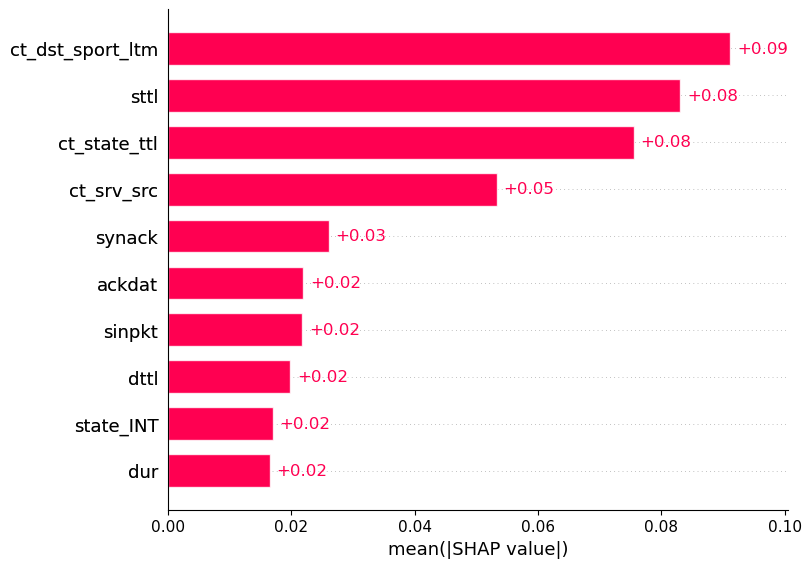

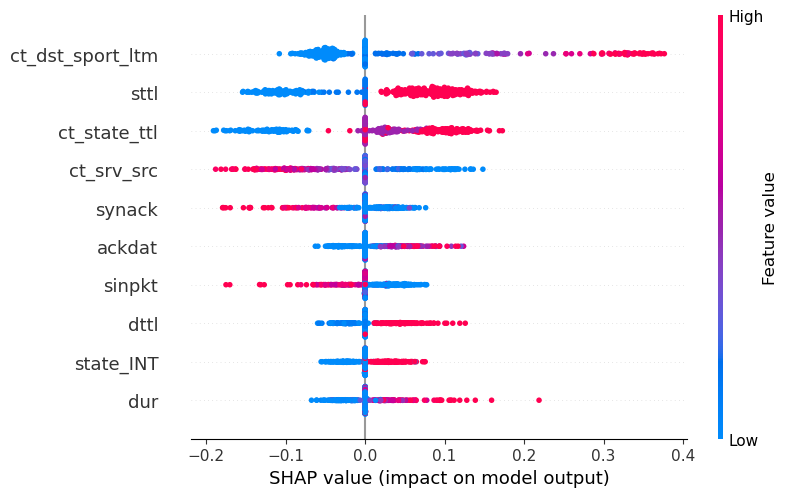


[BNN] SHAP Top-10 features:
            feature  mean_abs_shap
0  ct_dst_sport_ltm       0.091186
1              sttl       0.083100
2      ct_state_ttl       0.075496
3        ct_srv_src       0.053300
4            synack       0.026052
5            ackdat       0.021919
6            sinpkt       0.021783
7              dttl       0.019838
8         state_INT       0.017041
9               dur       0.016522


In [30]:
# SHAP

# 1) BNN probability prediction (posterior sampling average)
def bnn_predict_proba(X_np, S=50):
    bnn.eval()
    X_t = torch.from_numpy(np.asarray(X_np, dtype=np.float32)).to(device)
    with torch.no_grad():
        pred = Predictive(bnn, guide=guide, num_samples=S, return_sites=["obs"])
        p1 = pred(X_t)["obs"].float().mean(dim=0).cpu().numpy()  # P(y=1)
    p1 = np.clip(p1, 1e-7, 1 - 1e-7)
    return np.c_[1 - p1, p1]  # [P(y=0), P(y=1)]

# 2) Background / explanation set (smaller for speed)
rng = np.random.RandomState(42)
bg_idx   = rng.choice(Xtr_bal_sel.shape[0], min(200, Xtr_bal_sel.shape[0]), replace=False)
shap_idx = rng.choice(X_test_fe_sel.shape[0], min(400, X_test_fe_sel.shape[0]), replace=False)
X_bg, X_shap = Xtr_bal_sel[bg_idx], X_test_fe_sel[shap_idx]

# ==== KernelSHAP with single-column output to avoid multi-output ambiguity ====

# 3) Return only positive-class probability (shape: (n_samples,))
def bnn_proba_pos(X_np, S=50):
    bnn.eval()
    X_t = torch.from_numpy(np.asarray(X_np, dtype=np.float32)).to(device)
    with torch.no_grad():
        p1 = Predictive(bnn, guide=guide, num_samples=S, return_sites=["obs"])(X_t)["obs"] \
                .float().mean(dim=0).cpu().numpy()
    return np.clip(p1, 1e-7, 1 - 1e-7)

# 4) Initialize & compute SHAP (returns n×d matrix)
explainer = shap.KernelExplainer(bnn_proba_pos, X_bg)
sv = explainer.shap_values(X_shap, nsamples=100)  # np.ndarray or Explanation.values, shape (n,d)
sv_mat = sv.values if hasattr(sv, "values") else np.asarray(sv)

# 5) Align shapes (remove bias column, ensure row/col match regardless of feature list length)
X_plot = np.asarray(X_shap)
if sv_mat.shape[1] == X_plot.shape[1] + 1:  # Some versions add a constant column
    sv_mat = sv_mat[:, :-1]
n = min(sv_mat.shape[0], X_plot.shape[0])
d = min(sv_mat.shape[1], X_plot.shape[1])
sv_mat, X_plot = sv_mat[:n, :d], X_plot[:n, :d]

# 6) Feature names: use selected_features first, auto-fill if not enough
try:
    seed = list(selected_features)
except Exception:
    seed = []
feat_names = (seed[:d] + [f"feat_{i}" for i in range(len(seed), d)])

# === Only plot Top-10 features, remove "sum of N other features" completely ===
# Compute global importance and take top 10 columns
shap_abs = np.abs(sv_mat).mean(axis=0)
idx_top  = np.argsort(shap_abs)[::-1][:10]

# Construct an Explanation containing only the Top-10 features
feat_top = [feat_names[i] for i in idx_top]
# Calculate base_values (single-column output -> expected_value is scalar or length=1 array)
base_raw    = explainer.expected_value
base_scalar = float(np.asarray(base_raw).ravel()[0])
base_vals   = np.full(n, base_scalar)
exp_top = shap.Explanation(
    values=sv_mat[:, idx_top],
    base_values=base_vals,           # Use calculated base values
    data=X_plot[:, idx_top],
    feature_names=feat_top
)

# Plot (no "sum of ... other features" anymore)
shap.plots.bar(exp_top, show=True)
shap.plots.beeswarm(exp_top, show=True)

# Table (exactly matches the plots above)
shap_top10_bnn = (
    pd.DataFrame({"feature": feat_top, "mean_abs_shap": shap_abs[idx_top]})
      .sort_values("mean_abs_shap", ascending=False)
)
print("\n[BNN] SHAP Top-10 features:")
print(shap_top10_bnn)

### Local interpretation: LIME  (pick a sample with high uncertainty/false positive)

LIME explanation @ test index 158
ct_dst_sport_ltm <= 0.00 => -0.2064
-1.16 < sttl <= 0.00 => 0.1864
sinpkt > 0.94 => -0.1237
ackdat > 0.56 => 0.1187
dur > 0.99 => 0.1147
0.00 < dttl <= 0.88 => 0.1101
tcprtt > 0.79 => 0.0916
state_INT <= 0.00 => -0.0864
ct_dst_ltm <= -0.29 => 0.05
-0.12 < ct_srv_src <= 0.41 => -0.0481


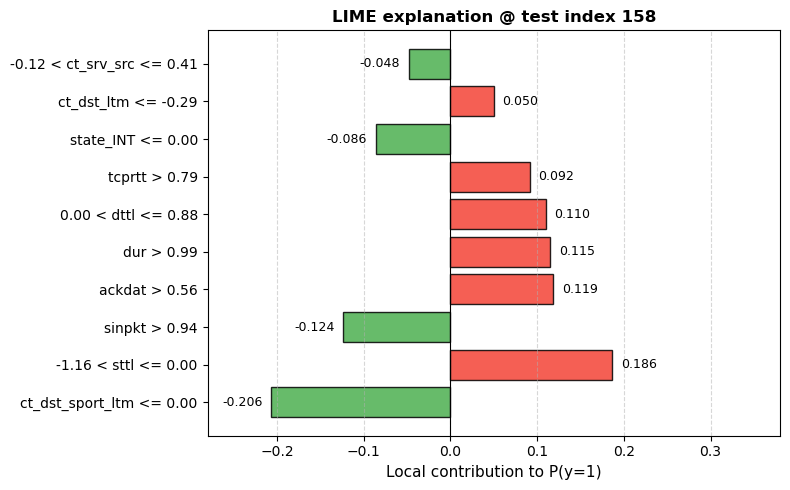

In [34]:
# Use training set as background distribution for LIME
explainer = LimeTabularExplainer(
    Xtr_bal_sel,
    feature_names=selected_features,
    class_names=['normal', 'attack'],
    discretize_continuous=True,
    mode='classification'
)

# BNN probability prediction function (reuses existing bnn/guide/device)
def bnn_predict_proba_fn(X):
    X_t = torch.from_numpy(X.astype(np.float32)).to(device)
    pred = Predictive(bnn, guide=guide, num_samples=100, return_sites=["obs"])
    with torch.no_grad():
        obs = pred(X_t)["obs"].float()  # Shape: [S, N]
    p = obs.mean(dim=0).cpu().numpy()
    return np.vstack([1 - p, p]).T  # Shape: (N, 2) -> [P(y=0), P(y=1)]

# Select a sample to explain: prioritize "high-uncertainty false positives"
pred_bnn = (y_prob >= m_best['threshold']).astype(int) if 'm_best' in globals() else (y_prob >= 0.5).astype(int)
fp_idx = np.where((y_test_np == 0) & (pred_bnn == 1))[0]
target_idx = int(fp_idx[np.argmax(y_entropy[fp_idx])]) if len(fp_idx) > 0 else int(np.argmax(y_entropy))

# Generate LIME explanation
exp = explainer.explain_instance(X_test_fe_sel[target_idx], bnn_predict_proba_fn, num_features=10)
print(f"LIME explanation @ test index {target_idx}")
for k, v in exp.as_list():
    print(k, "=>", round(v, 4))


lime_pairs = exp.as_list()
lime_feats = [k for k, _ in lime_pairs]
lime_vals = [v for _, v in lime_pairs]

colors = ['#F44336' if v > 0 else '#4CAF50' for v in lime_vals]

plt.figure(figsize=(8, 5))
bars = plt.barh(
    range(len(lime_feats))[::-1], 
    lime_vals[::-1],
    color=np.array(colors)[::-1],
    edgecolor='black',
    alpha=0.85
)

plt.yticks(range(len(lime_feats))[::-1], lime_feats[::-1], fontsize=10)
for bar, val in zip(bars, lime_vals[::-1]):
    plt.text(
        bar.get_width() + (0.01 if val > 0 else -0.01),
        bar.get_y() + bar.get_height()/2,
        f"{val:.3f}",
        va='center',
        ha='left' if val > 0 else 'right',
        fontsize=9
    )

plt.axvline(0, color='black', linewidth=0.8)  # 中心线
plt.xlabel("Local contribution to P(y=1)", fontsize=11)
plt.title(f"LIME explanation @ test index {target_idx}", fontsize=12, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.xlim(-0.28, 0.38)
plt.tight_layout()
plt.show()